# IRTM Assignment

# Eleftherios Tetteris

# Nikolaos Athanasopoulos

# NECESSARY INSTALLS

### At the end, there is a pip list and a pip freeze command for specific details on all installed packages

In [183]:
#!pip install shap

In [153]:
#!pip install lime --user

In [1]:
#!pip install openpyxl 

In [2]:
#!pip install --upgrade gensim

In [3]:
#!pip install plotly

In [4]:
#!pip install geocoder

In [5]:
#!pip install pycountry-convert

In [6]:
#!pip install pycountry

In [7]:
#!pip install folium

In [8]:
#!pip install geopy

In [9]:
#!pip install seaborn

In [10]:
#!pip install fastcoref

In [11]:
#!pip install flair

In [12]:
#nltk.download('names')

In [13]:
#nltk.download('omw-1.4')


In [14]:
#nltk.download('tagsets')

In [15]:
#!pip install svgling

In [16]:
#nltk.download('words')

In [17]:
#nltk.download('maxent_ne_chunker')

In [18]:
#!pip install tqdm

In [19]:
#!pip install wordcloud

In [20]:
#!python.exe -m pip install -U pip setuptools wheel

In [21]:
#!pip install -U spacy

In [22]:
#!python -m spacy download en_core_web_sm

In [23]:
#!pip install -U matplotlib

In [24]:
#!pip install pandas

In [25]:
#!pip install --user -U nltk

In [26]:
#nltk.download('stopwords')

In [27]:
#nltk.download('wordnet')

# IMPORTS

In [37]:
import re
import warnings
warnings.filterwarnings("ignore")

import spacy
from spacy import displacy
from spacy.tokens import Span
from spacy.matcher import Matcher 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import time
from scipy import linalg
import seaborn as sns
import scipy
import plotly.graph_objects as go


import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.tree import Tree
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.grammar import DependencyGrammar
from nltk.parse import (
     DependencyGraph,
     ProjectiveDependencyParser,
     NonprojectiveDependencyParser,
)

from nltk.tokenize import PunktSentenceTokenizer

from collections import Counter
import string
import numpy as np
import pandas as pd
from transformers import pipeline
from transformers import BertTokenizer, BertModel

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.metrics import cohen_kappa_score, classification_report, precision_recall_curve
import shap



# FUNCTIONS 

In [2]:
# read txt file and replace special characters

def text_split(file):
    file_content = open(file, encoding='utf8').read()
    new_text = file_content.replace('\n', " ")
    new_text = new_text.replace("_", "")
    new_text = new_text.replace("—", "")
    new_text = new_text.replace("       ", "")
    new_text = new_text.replace("      ", "")
    new_text = new_text.replace("     ", "")
    new_text = new_text.replace("    ", "")
    new_text = new_text.replace("   ", "")
    new_text = new_text.replace("\\" , "")
    new_text = new_text.replace("*" , "")
    
    new_text = new_text.replace('“', '')
    new_text = new_text.replace("”", "")
    new_text = new_text.replace("‘", "")
    new_text = new_text.replace("’", "")
    new_text = new_text.replace("•", "")
    new_text = new_text.replace("-","")

    
    return new_text

In [3]:
### return pos-tag of word according to NLTK

def pos_wordnet(word):
    NLTKtag = nltk.pos_tag([word])[0][1][0].upper()
    if NLTKtag.startswith('J'):
        return wordnet.ADJ
    elif NLTKtag.startswith('V'):
        return wordnet.VERB
    elif NLTKtag.startswith('N'):
        return wordnet.NOUN
    elif NLTKtag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    print(NLTKtag)

In [4]:
### LEMMATIZE text with POS tags

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_text(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, pos_wordnet(word)) for word, pos in pos_tagged_text])

In [5]:
### For smoothing the topic river, in order to make it look better

def gaussian_smooth(x, y, sd):
    weights = np.array([scipy.stats.norm.pdf(x, m, sd) for m in x])
    weights = weights / weights.sum(1)
    return (weights * y).sum(1)

# READING THE TXT FILES + REMOVING SPECIAL CHARACTERS

In [6]:
poirot_investigates = text_split("poirot_investigates.txt")
murder_on_the_links = text_split("murder_on_the_links.txt")
mysterious_affairs_at_styles = text_split("mysterious_affairs_of_styles.txt")
plymouth_express = text_split("plymouth_express.txt")
the_big_four = text_split("the_big_four.txt")
murder_of_roger_ackroyd = text_split('murder_of_roger_ackroyd.txt')

### Each file has some unecessary start and end parts which unfortunately are not standardized across all books, we need to remove them manually

In [7]:
head1, sep1, tail1 = poirot_investigates.partition('THE ENDEnd of the Project Gutenberg EBook of Poirot Investigates, by Agatha Christie')
head1, sep1, tail1 = head1.partition('POIROT INVESTIGATESPOIROT INVESTIGATESIThe Adventure of The Western Star')
poirot_investigates = tail1 

In [8]:
head2, sep2, tail2 = murder_on_the_links.partition('END OF THE PROJECT GUTENBERG EBOOK THE MURDER ON THE LINKS')
head2, sep2, tail2 = head2.partition('26 I Receive a Letter 27 Jack Renaulds Story 28 Journeys End1 A Fellow Traveller')
murder_on_the_links = tail2

In [9]:
head3, sep3, tail3 = mysterious_affairs_at_styles.partition('THE END END OF THE PROJECT GUTENBERG EBOOK THE MYSTERIOUS AFFAIR AT STYLES')
head3, sep3, tail3 = head3.partition('POIROT EXPLAINSCHAPTER I. I GO TO STYLES')
mysterious_affairs_at_styles = tail3

In [10]:
head4, sep4, tail4 = plymouth_express.partition('[Transcribers Note: This story appeared in the January 1924 issue of The Blue Book Magazine.]')
head4, sep4, tail4 = head4.partition('an exceptionallytalented writer.By Agatha Christie')
plymouth_express = tail4

In [11]:
head5, sep5, tail5 = the_big_four.partition('END OF THE PROJECT GUTENBERG EBOOK THE BIG FOUR')
head5, sep5, tail5 = head5.partition('IN THE FELSENLABYRYNTHTHE BIG FOUR 1. THE UNEXPECTED GUEST')
the_big_four = tail5

In [12]:
head6, sep6, tail6 = murder_of_roger_ackroyd.partition('THE END+==================================================================+‖')
head6, sep6, tail6 = head6.partition('ACKROYD CHAPTER IDR. SHEPPARD AT THE BREAKFAST TABLE')
murder_of_roger_ackroyd = tail6

In [13]:
all_texts_list = [mysterious_affairs_at_styles,
                  murder_on_the_links,
                  plymouth_express,
                  poirot_investigates,
                  murder_of_roger_ackroyd,
                  the_big_four]

In [14]:
all_texts_names = ['mysterious_affairs_at_styles',
                   'murder_on_the_links',
                   'plymouth_express',
                   'poirot_investigates',
                   'murder_of_roger_ackroyd',
                   'the_big_four']

# ENTITY EXTRACTION

### Entity extraction can be done with multiple libraries. Here, we will use FlairNLP and Spacy (because of the nice visualizations)

## FlairNLP


In [27]:
from flair.nn import Classifier
from flair.splitter import SegtokSentenceSplitter
from flair.data import Sentence

start = time.time()

splitter = SegtokSentenceSplitter()
tagger = Classifier.load('ner')

flair_ner_list = []


for ind, text in enumerate(all_texts_list):
    print(f"Tagging entities for text index={ind}")
    
    sentences = splitter.split(text)
    tagger.predict(sentences)
    
    temp_list = []
    
    for index, sentence in enumerate(sentences):
        temp_list.append(sentence.get_labels())
        
        
    flair_ner_list.append(temp_list) 
    
    print(f"Finished tagging entities for text index={ind}")
        

        
end = time.time()

print(f'The time to tag all Named Entities with Flair was: {end-start} seconds ') ### typically 150 seconds

2023-05-29 21:05:51,713 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Tagging entities for text index=0
Finished tagging entities for text index=0
Tagging entities for text index=1
2023-05-29 21:06:20,820 Warning: An empty Sentence was created! Are there empty strings in your dataset?
Finished tagging entities for text index=1
Tagging entities for text index=2
Finished tagging entities for text index=2
Tagging entities for text index=3
Finished tagging entities for text index=3
Tagging entities for text index=4
Finished tagging entities for text index=4
Tagging entities for text index=5
2023-05-29 21:07:47,467 Warning: An empty Sentence was created! Are there empty strings in your dataset?
Finished tagging entities for text index=5
The time to tag all Named Entities with Flair was: 142.3846492767334 seconds 


In [28]:
len(flair_ner_list)

6

In [29]:
for index, i in enumerate(flair_ner_list):
    
    print(f"The number of sentences for text = {all_texts_names[index]} is:")
    print(f"{len(flair_ner_list[index])}")
    print("-"*20)

The number of sentences for text = mysterious_affairs_at_styles is:
5326
--------------------
The number of sentences for text = murder_on_the_links is:
6323
--------------------
The number of sentences for text = plymouth_express is:
460
--------------------
The number of sentences for text = poirot_investigates is:
4832
--------------------
The number of sentences for text = murder_of_roger_ackroyd is:
7046
--------------------
The number of sentences for text = the_big_four is:
4997
--------------------


## Spacy

In [30]:
nlp = spacy.load("en_core_web_sm")

print(nlp.pipe_names)


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [31]:
start = time.time()


spacy_ner_list = []


for ind, text in enumerate(all_texts_list):
    print(f"Tagging entities for text index={ind}")
    
    doc = nlp(text)
    
    spacy_ner_list.append(doc.ents)
    

    
    print(f"Finished tagging entities for text index={ind}")
        

        
end = time.time()

print(f'The time to tag all Named Entities with Spacy was: {end-start} seconds ') ### typically 100 seconds

Tagging entities for text index=0
Finished tagging entities for text index=0
Tagging entities for text index=1
Finished tagging entities for text index=1
Tagging entities for text index=2
Finished tagging entities for text index=2
Tagging entities for text index=3
Finished tagging entities for text index=3
Tagging entities for text index=4
Finished tagging entities for text index=4
Tagging entities for text index=5
Finished tagging entities for text index=5
The time to tag all Named Entities with Spacy was: 93.50998616218567 seconds 


In [32]:
len(spacy_ner_list)

6

In [33]:
for index, i in enumerate(spacy_ner_list):
    print(f"The number of entities in text = {all_texts_names[index]} is:")
    print(len(spacy_ner_list[index]))
    print("-"*20)

The number of entities in text = mysterious_affairs_at_styles is:
2803
--------------------
The number of entities in text = murder_on_the_links is:
2915
--------------------
The number of entities in text = plymouth_express is:
246
--------------------
The number of entities in text = poirot_investigates is:
2716
--------------------
The number of entities in text = murder_of_roger_ackroyd is:
3680
--------------------
The number of entities in text = the_big_four is:
2573
--------------------


# NAMED ENTITY RECOGNITION QUANTITATIVE RESULTS

## picking the test sentences 

In [34]:
### mysterious affairs at styles
test_sentence1 = 'Lawrence, the younger, had been a delicate youth. He had qualified as a doctor but early relinquished the profession of medicine, and lived at home while pursuing literary ambitions; though his verses never had any marked success.'
test_sentence2 = 'Mrs. Inglethorp, however, seemed to notice nothing unusual.'
test_sentence3 = 'I need not tell you, my dear Cavendish, how distressed I am at this most tragic affair.'
test_sentence4 = 'I, Hercule Poirot, affirm that the man who entered the chemists shop, and purchased strychnine at six oclock on Monday last was not Mr. Inglethorp, for at six oclock on that day Mr. Inglethorp was escorting Mrs. Raikes back to her home from a neighbouring farm.'

### murder on the links
test_sentence5 = 'Before starting Poirot had despatched a telegram to Mr. Renauld giving the time of our arrival at Calais.'
test_sentence6 = 'With mutual civilities, we parted company, Poirot and I going towards Merlinville, and the others returning to the Villa Geneviève. '
test_sentence7 = ' And then, towards the close of the trial, a letter, posted in Paris, was sent to the Public Prosecutor.'
test_sentence8 = 'The Dulcibella Sisters are on at the Palace in Coventry.'


### plymouth express
test_sentence9 = 'Alec Simpson, R. N., stepped from the platform at Newton Abbot into a firstclass compartment of the Plymouth Express.'
test_sentence10 = 'Halliday rang the bell, and gave a short order to the footman.'
test_sentence11 = 'It is with infinite pleasure that I look forward to thefelicity of meeting you again.'
test_sentence12 = 'Now, Mr. Halliday, let me introduce you to Grace Kidd, otherwise Jane Mason, who will shortly rejoin her accomplice, Red Narky, under the kind escort of Japp.'


### poirot investigates
test_sentence13 = 'Also I wanted to ask of Lady Yardly if she recollected at all the postmarks on the letters she received?'
test_sentence14 = 'Beyond the fact that he spoke like an American I didnt notice much about him. '
test_sentence15 = 'It is the universal opinion that the turning point of the Conference will be the strong personality of the Prime Minister.'
test_sentence16 = 'So, said Poirot thoughtfully, there are two disappearances: the Prime Minister in France, and OMurphy in London.'


### murder of roger ackroyd
test_sentence17 = 'It is the only place adjacent to the village of Kings Abbot where you can talk with a young woman unseen by the whole of the village. '
test_sentence18 = 'With him was Colonel Melrose, the Chief Constable, and another man whom, from Floras description of weaselly, I had no difficulty in recognizing as Inspector Raglan from Cranchester.'
test_sentence19 = 'The super detective always has his rooms littered with rubies and pearls and emeralds from grateful Royal clients.'
test_sentence20 = 'He smiled at us both with that engaging frankness that made him such a likable youngster.'


### the big four
test_sentence21 = 'Leaving our mysterious visitor in the charge of Mrs. Pearson, we drove away, and duly caught the train by the skin of our teeth.'
test_sentence22 = 'Damned ingenious!" cried Ingles approvingly.'
test_sentence23 = ' It was in response to this wire that, about a month after my adventure in Abe Rylands house, we found ourselves alone in a railway compartment whirling away from the smoke and dust of London, bound for the little town of Market Handford in Worcestershire, the seat of the mystery. '
test_sentence24 = 'Why, I remember once at Manchester"  We displayed what patience we could in listening to a long complicated story about a pantomime, and the infamous conduct of the principal boy.'



In [35]:
test_sentences_ner = [test_sentence1, 
                      test_sentence2, 
                      test_sentence3,
                      test_sentence4,
                      test_sentence5,
                      test_sentence6,
                      test_sentence7,
                      test_sentence8,
                      test_sentence9,
                      test_sentence10,
                      test_sentence11,
                      test_sentence12,
                      test_sentence13,
                      test_sentence14,
                      test_sentence15,
                      test_sentence16,
                      test_sentence17,
                      test_sentence18,
                      test_sentence19,
                      test_sentence20,
                      test_sentence21,
                      test_sentence22,
                      test_sentence23,
                      test_sentence24]

In [38]:
nlp = spacy.load("en_core_web_sm")
spacy_entities_measure = []
flair_entities_measure = []
for index, test_sentence in enumerate(test_sentences_ner):
    
    print(f"Printing results for sentence number {index+1}")
    print(f'The sentence is:\n{test_sentence}')
    sentence = Sentence(test_sentence)
    tagger.predict(sentence)
    
    for label in sentence.get_labels():
        
        print(f"\nFor FlairNLP, the results are:")
        print(f'the text of label.data_point is:{label.data_point.text}')
        # print label value and score
        print(f'label.value is: "{label.value}"')
        #print(f'label.score is: "{label.score}"')
        # access the data point to which label attaches and print its text
        flair_entities_measure.append(label.value)
        
        
        
        print(f"\nFor Spacy, the results are:")
        doc = nlp(label.data_point.text)
        print(doc.ents)
        
        if len(doc.ents)>0:
            
            print(doc.ents[0].label_)
            spacy_entities_measure.append(doc.ents[0].label_[:3])
            
        else:
            spacy_entities_measure.append("")
          
        print('-'*20)      
        
         

Printing results for sentence number 1
The sentence is:
Lawrence, the younger, had been a delicate youth. He had qualified as a doctor but early relinquished the profession of medicine, and lived at home while pursuing literary ambitions; though his verses never had any marked success.

For FlairNLP, the results are:
the text of label.data_point is:Lawrence
label.value is: "PER"

For Spacy, the results are:
()
--------------------
Printing results for sentence number 2
The sentence is:
Mrs. Inglethorp, however, seemed to notice nothing unusual.

For FlairNLP, the results are:
the text of label.data_point is:Inglethorp
label.value is: "PER"

For Spacy, the results are:
(Inglethorp,)
ORG
--------------------
Printing results for sentence number 3
The sentence is:
I need not tell you, my dear Cavendish, how distressed I am at this most tragic affair.

For FlairNLP, the results are:
the text of label.data_point is:Cavendish
label.value is: "PER"

For Spacy, the results are:
(Cavendish,)
NO


For FlairNLP, the results are:
the text of label.data_point is:Melrose
label.value is: "PER"

For Spacy, the results are:
()
--------------------

For FlairNLP, the results are:
the text of label.data_point is:Inspector Raglan
label.value is: "PER"

For Spacy, the results are:
(Raglan,)
PERSON
--------------------

For FlairNLP, the results are:
the text of label.data_point is:Cranchester
label.value is: "LOC"

For Spacy, the results are:
()
--------------------
Printing results for sentence number 19
The sentence is:
The super detective always has his rooms littered with rubies and pearls and emeralds from grateful Royal clients.
Printing results for sentence number 20
The sentence is:
He smiled at us both with that engaging frankness that made him such a likable youngster.
Printing results for sentence number 21
The sentence is:
Leaving our mysterious visitor in the charge of Mrs. Pearson, we drove away, and duly caught the train by the skin of our teeth.

For FlairNLP, the results 

### The results from above, as well as our annotations for the same sentences, are coded into an excel for easier annotation. We now load this file and present it here

In [39]:
df = pd.read_excel('results_ner.xlsx')

In [40]:
df

sentence              entity Flair Spacy annotator1 annotator2
0          0            Lawrence   PER     -        PER        PER
1          1          Inglethorp   PER   ORG        PER        PER
2          2           Cavendish   PER  NORP        PER        PER
3          3      Hercule Poirot   PER   PER        PER        PER
4          3          Inglethorp   PER   ORG        PER        PER
5          3              Raikes   PER   PER        PER        PER
6          4              Poirot   PER     -        PER        PER
7          4             Renauld   PER     -        PER        PER
8          4              Calais   LOC   PER        LOC        LOC
9          5         Merlinville   LOC   PER        LOC        LOC
10         5     Villa genevieve   ORG   ORG        LOC        LOC
11         6               Paris   LOC   LOC        LOC        LOC
12         6   Public Prosecutor   ORG     -        ORG        ORG
13         7  Dulcibella Sisters  MISC   ORG        PER        PER
14         7            Coventry   LOC     -        LOC        LOC
15         8        Alec Simpson   PER   PER        PER        PER
16         8        Newton Abbot   LOC   PER        LOC        PER
17         8    Plymouth Express   LOC   ORG        LOC        LOC
18         9            Halliday   PER     -        PER        PER
19        10                   -     -     -          -          -
20        11          Grace Kidd   PER   PER        PER        PER
21        11          Jane Mason   PER   PER        PER        PER
22        11           Red Narky   PER   ORG        PER        PER
23        11                Japp   PER     -        PER        PER
24        12         Lady Yardly   PER   PER        PER        PER
25        13            American  MISC  NORP       NORP       NORP
26        14          Conference   ORG     -       MISC        ORG
27        15      Prime Minister     -     -        PER        PER
28        15              France   LOC   LOC        LOC        LOC
29        15             Omurphy   LOC     -        PER        PER
30        15              London   LOC   LOC        LOC        LOC
31        16         Kings Abbot   LOC   PER        LOC        LOC
32        17     Colonel Melrose   PER     -        PER        PER
33        17     Chief Constable     -     -        PER       NORP
34        17    Inspector Raglan   PER   PER        PER        PER
35        17         Cranchester   LOC     -        LOC        LOC
36        20             Pearson   PER     -        PER        PER
37        21              Ingles   PER     -        PER        PER
38        22         Abe Rylands   LOC   PER        PER        PER
39        22              London   LOC   LOC        LOC        LOC
40        22     Market Handford   LOC     -        LOC        LOC
41        22      Worcestershire   LOC   LOC        LOC        LOC
42        23          Manchester   LOC     -        LOC        LOC

In [41]:
cohen_kappa_score(df['annotator1'], df['Spacy'])

0.17534246575342471

In [42]:
cohen_kappa_score(df['annotator1'], df['Flair'])

0.6995633187772925

In [43]:
cohen_kappa_score(df['annotator2'], df['Flair'])

0.703448275862069

In [44]:
cohen_kappa_score(df['annotator1'], df['annotator2'])

0.8780718336483933

In [47]:
print(classification_report(df['annotator1'], df['Flair']))

              precision    recall  f1-score   support

           -       0.33      1.00      0.50         1
         LOC       0.88      0.93      0.90        15
        MISC       0.00      0.00      0.00         1
        NORP       0.00      0.00      0.00         1
         ORG       0.33      1.00      0.50         1
         PER       1.00      0.79      0.88        24

    accuracy                           0.81        43
   macro avg       0.42      0.62      0.46        43
weighted avg       0.88      0.81      0.83        43



In [48]:
print(classification_report(df['annotator1'], df['Spacy']))

              precision    recall  f1-score   support

           -       0.06      1.00      0.11         1
         LOC       1.00      0.33      0.50        15
        MISC       0.00      0.00      0.00         1
        NORP       0.50      1.00      0.67         1
         ORG       0.00      0.00      0.00         1
         PER       0.67      0.33      0.44        24

    accuracy                           0.35        43
   macro avg       0.37      0.44      0.29        43
weighted avg       0.73      0.35      0.44        43



# FIND MOST MENTIONED CHARACTERS IN BOOKS

In [17]:
from flair.nn import Classifier
from flair.data import Sentence
from flair.splitter import SegtokSentenceSplitter
# load the model
tagger = Classifier.load('ner-fast')

2023-05-30 19:32:48,139 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [18]:
start = time.time()


entities_text = poirot_investigates + murder_on_the_links + mysterious_affairs_at_styles + the_big_four + murder_of_roger_ackroyd + plymouth_express 

# initialize sentence splitter
splitter = SegtokSentenceSplitter()

# use splitter to split text into list of sentences
sentences = splitter.split(entities_text)

# predict tags for sentences
tagger.predict(sentences)

end = time.time()

print(f"The time to tag all NE with FlairNLP was: {end-start} seconds") ### typically 250 seconds



The time to tag all NE with FlairNLP was: 249.42992615699768 seconds


In [19]:
flair_entities_full = []
flair_entities_names = []
flair_entities_sentences = []

### A location is added to the list only if the name Hastings is mentioned in the same sentence, the previous one or the next one.
### This is done to somewhat skip the times that someone is introduced and hastings is not there
### Of course there are limitations which are discussed in the report


# iterate through sentences and print predicted labels
for index, sentence in enumerate(sentences):
    if len(sentence.get_labels()) > 0:
        for label in sentence.get_labels():
            # print label value and score
            #print(f'label.value is: "{label.value}"')
            #print(f'label.score is: "{label.score}"')
            # access the data point to which label attaches and print its text
            #print(f'the text of label.data_point is: "{label.data_point.text}"\n')
            if label.value == "PER" :
                flair_entities_full.append(label)
                flair_entities_names.append(label.data_point.text)
                flair_entities_sentences.append(sentence)

In [21]:
print(len(flair_entities_full))
print(len(flair_entities_names))
print(len(flair_entities_sentences))

9050
9050
9050


In [30]:
flair_entities_sentences[0].get_labels()[0].data_point.text

'Poirot'

In [32]:
cnt_entities = Counter()

for index, enti in enumerate(flair_entities_sentences):
    cnt_entities[flair_entities_sentences[index].get_labels()[0].data_point.text]+=1
 



In [36]:
cnt_entities.most_common(20)

[('Poirot', 1727),
 ('Hastings', 238),
 ('Ackroyd', 212),
 ('Caroline', 177),
 ('Inglethorp', 176),
 ('Renauld', 152),
 ('Parker', 151),
 ('Giraud', 136),
 ('Japp', 131),
 ('John', 119),
 ('Ive', 112),
 ('Flora', 107),
 ('Hercule Poirot', 92),
 ('Monsieur Poirot', 85),
 ('M. Poirot', 83),
 ('Sheppard', 82),
 ('Ralph', 80),
 ('Jack Renauld', 76),
 ('Raymond', 75),
 ('Miss Howard', 74)]

# TOPIC MODELLING

Topic modelling is going to be performed with NMF and LDA

## NMF

If we perform topic modelling without lemmatization, some words like said are going to be present in the topics. This is why we will perform lemmatization (with POS tags) first

In [49]:
start = time.time()

lemmatized_texts = []

for index, text in enumerate(all_texts_list):
    
    print(f"Lemmatizing text = {all_texts_names[index]}")
    
    lemmatized_texts.append(lemmatize_text(text))
    
    print(f"\nFinished Lemmatizing text = {all_texts_names[index]}\n")

    
end = time.time()

print(f"\nThe time to lemmatize all texts was: {end-start} seconds") ###typically 200 seconds

Lemmatizing text = mysterious_affairs_at_styles

Finished Lemmatizing text = mysterious_affairs_at_styles

Lemmatizing text = murder_on_the_links

Finished Lemmatizing text = murder_on_the_links

Lemmatizing text = plymouth_express

Finished Lemmatizing text = plymouth_express

Lemmatizing text = poirot_investigates

Finished Lemmatizing text = poirot_investigates

Lemmatizing text = murder_of_roger_ackroyd

Finished Lemmatizing text = murder_of_roger_ackroyd

Lemmatizing text = the_big_four

Finished Lemmatizing text = the_big_four


The time to lemmatize all texts was: 176.2176218032837 seconds


In [50]:
len(lemmatized_texts)

6

In [51]:
def get_topics(components): 
    for i, comp in enumerate(components):
        terms_comp = zip(vocab,comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[1:30] ### change numbers to get different topic words
        topic=" "
        for t in sorted_terms:
            topic= topic + ' ' + t[0]
        topic_word_list.append(topic)
        #print(topic_word_list)
    return topic_word_list

In [52]:
# def get_topics2(components): 
#     topic_word_list = []  # Initialize an empty list to store topics
    
#     for i, comp in enumerate(components):
#         terms_comp = zip(vocab, comp)
#         sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[0:30]  # Change numbers to get different topic words
#         topic = [t[0] for t in sorted_terms]  # Create a list of words for the topic
#         topic_word_list.append(topic)
    
#     return topic_word_list


# topic_word_list = []

# topics_words2 = get_topics2(H)

In [53]:
documents = lemmatized_texts  # List of preprocessed documents

vectorizer = TfidfVectorizer(stop_words='english', smooth_idf=True)
dtm = vectorizer.fit_transform(documents)


num_topics = 20
nmf_model = NMF(n_components=num_topics, random_state=42, max_iter=1000)

W = nmf_model.fit_transform(dtm)
H = nmf_model.components_

vocab = vectorizer.get_feature_names_out()

topic_word_list = []

get_topics(H)

['  say come know man little make time look think hand friend yes way ask just like door thing quite face good left tell case saw old room day said',
 '  bristol halliday carrington man mason know say weston monsieur come daughter jane japp think maid good rupert plymouth train narky yes taunton little make rochefour carriage flossie said return',
 '  giraud jack daubreuil magistrate madame hautet marthe renaulds bella monsieur commissary dagger bex girl villa crime stonor françoise duveen head merlinville juge beroldy conneau moment dont hastings georges love',
 '  say caroline flora ralph miss blunt parker mr paton raymond know said inspector dont mrs sheppard come im think just minute ursula ive russell sir fernly ackroyds ferrars dr',
 '  carrington mason halliday monsieur weston sir maid daughter jane rupert japp plymouth good narky taunton rochefour dont count train mistress carriage mrs jewels poirot return london flossie friend compartment',
 '  caroline flora ralph blunt parke

In [54]:
print(W.shape)

print(H.shape)

(6, 20)
(20, 13980)


In [55]:
# manual_topic1 = ['look', 'think', 'time', 'friend', 'door', 'face','room']
# manual_topic2 = ['halliday', 'carrington', 'man', 'mason', 'weston', 'jane', 'japp', 'train', 'plymouth']
# manual_topic3 = ['magistrate', 'commissary', 'dagger', 'villa', 'crime', 'judge']
# manual_topic4 = ['caroline', 'flora', 'miss', 'blunt', 'mrs', 'sheppard', 'ursula', 'ferrars']
# manual_topic5 = ['maid', 'daughter', 'jane', 'plymouth', 'flossie', 'jewels', 'mistress' 'friend']
# manual_topic6 = ['ursula', 'ganett', 'sister', 'dictaphone', 'secretary', 'blackmail']
# manual_topic7 = ['strychnine', 'mother', 'poison', 'suddenly', 'hastings', 'wells']
# manual_topic8 = ['moment', 'head', 'truth', 'miss', 'girl', 'mademoiselle', 'question']
# manual_topic9 = ['mrs', 'mr', 'cavendish', 'tell', 'little', 'believe', 'quite', 'tell']
# manual_topic10 = ['shook', 'bed', 'remember', 'manner', 'understand', 'lead', 'star', 'new', 'eyes']
# manual_topic11 = ['magistrate', 'comissary', 'francoise', 'villa', 'genevieve', 'buenos', 'ayres']
# manual_topic12 = ['hastings', 'dont', 'yardly', 'cried', 'dr', 'wife', 'london', 'understand']
# manual_topic13 = ['lead', 'hercule', 'sir', 'wife', 'insepctor', 'manner', 'understand']
# manual_topic14 = ['big', 'chang', 'li', 'savaronoff', 'chinaman', 'countess', 'chinese', 'ling']
# manual_topic15 = ['poirot', 'poirots', 'yardly', 'police', 'minister', 'lord', 'shot']
# manual_topic16 = ['prime', 'minister', 'chambermaid', 'lord', 'necklace', 'revolver', 'foscatini', 'dinner']
# manual_topic17 = ['taken', 'statement', 'pond', 'facts', 'accepted', 'handle', 'voices', 'nervously']
# manual_topic18 = ['examine', 'transparent', 'remark', 'clues', 'admitting', 'erroneous']
# manual_topic19 = ['telephone', 'dinner', 'receive', 'force', 'wall', 'wall', 'visitor']
# manual_topic20 = ['measure', 'ground', 'command', 'operations', 'laughing', 'revenge', 'powerful', 'guard']

manual_topic1 = ['look', 'think', 'time', 'friend', 'door', 'face','room']
manual_topic2 = ['halliday', 'mason', 'weston', 'jane', 'japp', 'train', 'plymouth']
manual_topic3 = ['magistrate', 'commissary', 'dagger', 'villa', 'crime', 'judge', 'merlinville']
manual_topic4 = ['caroline', 'flora', 'miss', 'blunt', 'sheppard', 'ursula', 'ferrars']
manual_topic5 = ['maid', 'daughter', 'jane', 'plymouth', 'flossie', 'jewels', 'mistress' 'friend']
manual_topic6 = ['ursula', 'ganett', 'sister', 'dictaphone', 'secretary', 'blackmail', 'summerhouse']
manual_topic7 = ['strychnine', 'mother', 'poison', 'suddenly', 'hastings', 'wells', 'dorcas']
manual_topic8 = ['moment', 'head', 'truth', 'miss', 'girl', 'mademoiselle', 'question']
manual_topic9 = ['mrs', 'mr', 'cavendish', 'tell', 'little', 'believe', 'tell']
manual_topic10 = ['shook', 'bed', 'remember', 'manner' ,'lead', 'star', 'new']
manual_topic11 = ['magistrate', 'comissary', 'francoise', 'villa', 'genevieve', 'buenos', 'ayres']
manual_topic12 = ['hastings', 'dont', 'yardly', 'cried', 'dr', 'wife', 'london']
manual_topic13 = ['lead', 'hercule', 'sir', 'wife', 'insepctor', 'manner', 'understand']
manual_topic14 = ['big', 'chang', 'li', 'savaronoff', 'chinaman', 'countess', 'chinese']
manual_topic15 = ['poirot', 'poirots', 'yardly', 'police', 'minister', 'lord', 'shot']
manual_topic16 = ['prime', 'minister', 'chambermaid', 'lord', 'necklace', 'revolver', 'dinner']
manual_topic17 = ['taken', 'statement', 'facts', 'accepted', 'handle', 'voices', 'nervously']
manual_topic18 = ['examine', 'transparent', 'remark', 'clues', 'admitting', 'erroneous', 'convalescent']
manual_topic19 = ['telephone', 'dinner', 'receive', 'force', 'wall', 'wall', 'visitor']
manual_topic20 = ['measure', 'ground', 'command', 'operations', 'laughing', 'revenge', 'powerful']

In [56]:
manual_topic_list = [manual_topic1,
                    manual_topic2,
                    manual_topic3,
                    manual_topic4,
                    manual_topic5,
                    manual_topic6,
                    manual_topic7,
                    manual_topic8,
                    manual_topic9,
                    manual_topic10,
                    manual_topic11,
                    manual_topic12,
                    manual_topic13,
                    manual_topic14,
                    manual_topic15,
                    manual_topic16,
                    manual_topic17,
                    manual_topic18,
                    manual_topic19,
                    manual_topic20]

print(len(manual_topic_list))


for index, i in enumerate(manual_topic_list):
    print(f'index is {index+1}')
    print(len(i))
    print('-'*20)

20
index is 1
7
--------------------
index is 2
7
--------------------
index is 3
7
--------------------
index is 4
7
--------------------
index is 5
7
--------------------
index is 6
7
--------------------
index is 7
7
--------------------
index is 8
7
--------------------
index is 9
7
--------------------
index is 10
7
--------------------
index is 11
7
--------------------
index is 12
7
--------------------
index is 13
7
--------------------
index is 14
7
--------------------
index is 15
7
--------------------
index is 16
7
--------------------
index is 17
7
--------------------
index is 18
7
--------------------
index is 19
7
--------------------
index is 20
7
--------------------


In [57]:
for i in manual_topic_list:
    print(i)
    print('')

['look', 'think', 'time', 'friend', 'door', 'face', 'room']

['halliday', 'mason', 'weston', 'jane', 'japp', 'train', 'plymouth']

['magistrate', 'commissary', 'dagger', 'villa', 'crime', 'judge', 'merlinville']

['caroline', 'flora', 'miss', 'blunt', 'sheppard', 'ursula', 'ferrars']

['maid', 'daughter', 'jane', 'plymouth', 'flossie', 'jewels', 'mistressfriend']

['ursula', 'ganett', 'sister', 'dictaphone', 'secretary', 'blackmail', 'summerhouse']

['strychnine', 'mother', 'poison', 'suddenly', 'hastings', 'wells', 'dorcas']

['moment', 'head', 'truth', 'miss', 'girl', 'mademoiselle', 'question']

['mrs', 'mr', 'cavendish', 'tell', 'little', 'believe', 'tell']

['shook', 'bed', 'remember', 'manner', 'lead', 'star', 'new']

['magistrate', 'comissary', 'francoise', 'villa', 'genevieve', 'buenos', 'ayres']

['hastings', 'dont', 'yardly', 'cried', 'dr', 'wife', 'london']

['lead', 'hercule', 'sir', 'wife', 'insepctor', 'manner', 'understand']

['big', 'chang', 'li', 'savaronoff', 'chinama

## LDA

In [58]:
no_features = 1000
tf_vectorizer = CountVectorizer(stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names_out()


lda = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
display_topics(lda, tf_feature_names, no_top_words)


Topic 0:
poirot say know come little man look mr make mrs think friend time yes ask said quite miss tell renauld
Topic 1:
poirot say man come know yes mr hand look head mrs little make thing like room friend door ask quite
Topic 2:
poirot say come know man make little think mr mrs look yes ask time door quite ackroyd just said way
Topic 3:
poirot say man come know make yes time mr mrs little look think said just way ask hand friend miss
Topic 4:
poirot say know come man mr little look make yes time mrs think said hand door ask friend just way


# TOPIC RIVER

In [59]:
print(W.shape)
print(H.shape)

(6, 20)
(20, 13980)


In [60]:
topic_list = []
for i in range(W.shape[1]):
    topic_list.append(W[::,i])

In [61]:
len(topic_list)

20

In [62]:
labels_list = []
for i in range(W.shape[1]):
    labels_list.append('topic'+str(i))
    
    
print(labels_list)    

['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 'topic19']


In [63]:
colors_test = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#800080', '#00FF00', '#FF00FF', '#00FFFF',
          '#FF0000', '#008000', '#0000FF', '#808080', '#800000', '#008080', '#FF4500', '#800000']

In [64]:
# from matplotlib.colors import LinearSegmentedColormap

# colors_grad = plt.cm.get_cmap('viridis', len(topic_list))

In [65]:
#colors_grad_list = [colors_grad(i) for i in range(len(topic_list))]

In [67]:
sorted_data = sorted(topic_list, key=lambda x: sum(x), reverse=True)
sorted_topics = [topic for _, topic in sorted(zip(topic_list, labels_list), key=lambda x: sum(x[0]), reverse=True)]
sorted_top_words = [words for _, words in sorted(zip(topic_list, get_topics(H)), key=lambda x: sum(x[0]), reverse=True)]

# x_axis = np.arange(W.shape[0])
# fig, ax = plt.subplots(figsize=(20, 15), dpi=100)
# plt.stackplot(x_axis, sorted_data, baseline='weighted_wiggle', labels = sorted_top_words)
# plt.legend(loc='upper left')
# plt.show()

### Smoothed Topic River

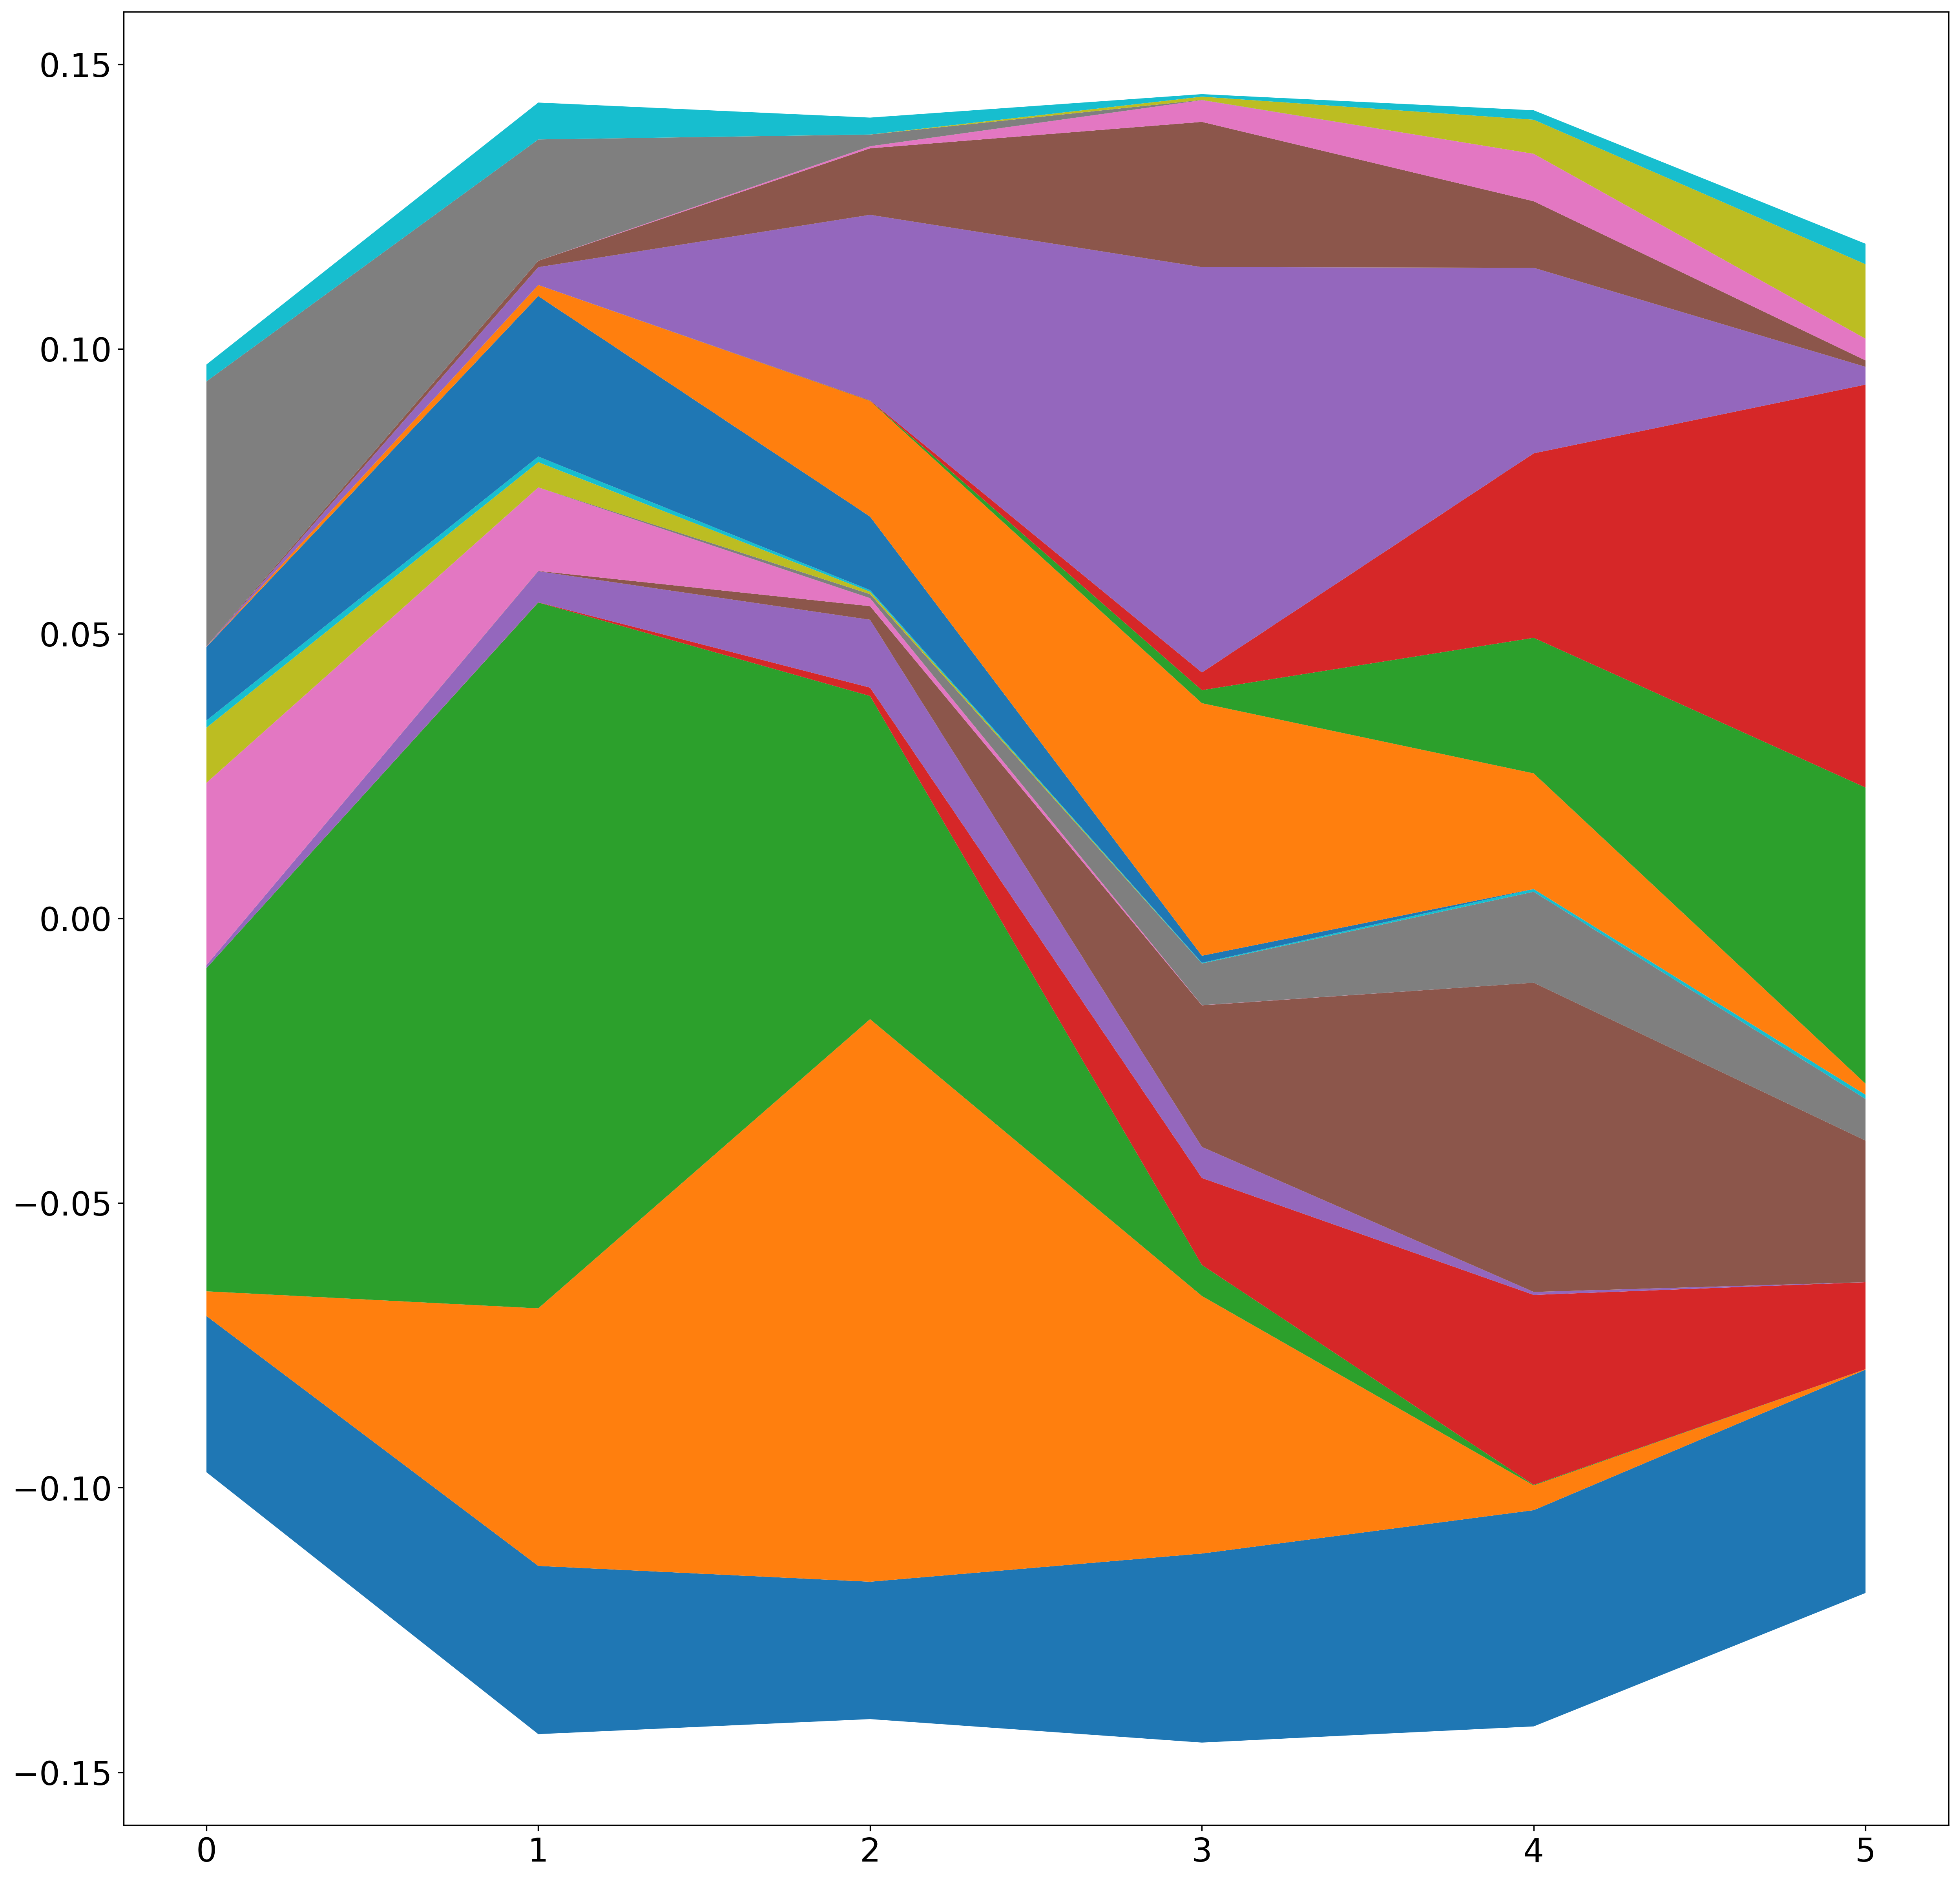

In [68]:
fig, ax = plt.subplots(figsize=(20, 20), dpi=300)
y_smoothed = [gaussian_smooth(x_axis, y_, 0.8) for y_ in topic_list]

ax.stackplot(x_axis, y_smoothed, baseline="sym", labels = manual_topic_list)
# Adjust x-axis tick label font size
ax.tick_params(axis='x', labelsize=20)  # Set desired font size

# Adjust y-axis tick label font size
ax.tick_params(axis='y', labelsize=20)  # Set desired font size

#legend = ax.legend()
#handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
plt.savefig('topic_river.png')
#legend_fig = plt.figure()
#legend_fig.legend(handles, labels)
#legend_fig.savefig('legend_topic_river.png');
#plt.show()

## Topic coherence scores

NMF

In [69]:
from sklearn.metrics.pairwise import cosine_similarity

corpus = all_texts_list

num_topics = 10
num_top_words = 25


vectorizer = TfidfVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(corpus)

nmf_model = NMF(n_components=num_topics)
nmf_model.fit(dtm)

feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = []

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    top_words_per_topic.append(top_words)

coherence_scores = []
word_cooccurrence = dtm.T.dot(dtm)

for topic_words in top_words_per_topic:
    topic_words_indices = [vectorizer.vocabulary_[word] for word in topic_words]
    pairwise_similarities = cosine_similarity(word_cooccurrence[topic_words_indices][:, topic_words_indices])
    coherence_score = np.mean(np.triu(pairwise_similarities, k=1))
    coherence_scores.append(coherence_score)

average_coherence = np.mean(coherence_scores)
print("Average Coherence Score:", average_coherence)


Average Coherence Score: 0.45897429610679713


LDA

In [70]:

corpus = all_texts_list

num_topics = 10
num_top_words = 25

vectorizer = TfidfVectorizer(stop_words='english')
bow_matrix = vectorizer.fit_transform(corpus)

lda_model = LatentDirichletAllocation(n_components=num_topics)
lda_model.fit(bow_matrix)

feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = []

for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    top_words_per_topic.append(top_words)

coherence_scores = []
word_cooccurrence = bow_matrix.T.dot(bow_matrix)

for topic_words in top_words_per_topic:
    topic_words_indices = [vectorizer.vocabulary_[word] for word in topic_words]
    pairwise_similarities = cosine_similarity(word_cooccurrence[topic_words_indices][:, topic_words_indices])
    coherence_score = np.mean(np.triu(pairwise_similarities, k=1))
    coherence_scores.append(coherence_score)

average_coherence = np.mean(coherence_scores)
print("Average Coherence Score:", average_coherence)


Average Coherence Score: 0.34472200442794715


# CO-REFERENCE HANDLING

The next step is to perform Co-reference handling, because otherwise a lot of information will be missed in the next steps. The 2 ways of handling co-references are with Spacy-NeuralCoref and with FastCoref


## Spacy-NeuralCoref

Before resolving the co-references, we need to split the big texts into halves because NeuralCoref and spacy cannot process the whole text in one pass (throwing a RAM error)

The big texts are: poirot investigates, murder on the links, mysterious affairs at styles, big four, murder of roger ackroyd


In [19]:
big_texts = [poirot_investigates, murder_on_the_links, mysterious_affairs_at_styles, the_big_four, murder_of_roger_ackroyd, plymouth_express]

big_texts_names = ['poirot_investigates', 'murder_on_the_links', 'mysterious_affairs_at_styles', 'the_big_four', 'murder_of_roger_ackroyd', 'plymouth_express']


In [20]:
for big_text, big_text_name in zip(big_texts, big_texts_names):
    
    big_text_first_half, big_text_second_half = big_text[:len(big_text)//2], big_text[len(big_text)//2:]
    
    
    filename_first_half = big_text_name+'_first_half.txt'
    name_first_half = open(filename_first_half, 'w', encoding='utf8')
    name_first_half.write(big_text_first_half)
    name_first_half.close()
    
    filename_second_half = big_text_name+'_second_half.txt'
    name_second_half = open(filename_second_half, 'w', encoding='utf8')
    name_second_half.write(big_text_second_half)
    name_second_half.close()    


### Now we have every big text in half, so that we can work on it with NeuralCoref

### upload files to Google colab, work on them with neuralcoref and then download them

In [18]:
resolved_poirot_investigates = text_split('RESOLVED_poirot_investigates.txt')
resolved_murder_on_the_links = text_split('RESOLVED_murder_on_the_links.txt')
resolved_mysterious_affairs_at_styles = text_split('RESOLVED_mysterious_affairs_at_styles.txt')
resolved_the_big_four = text_split('RESOLVED_the_big_four.txt')
resolved_murder_of_roger_ackroyd = text_split('RESOLVED_murder_of_roger_ackroyd.txt')
resolved_plymouth_express = text_split('RESOLVED_plymouth_express.txt')


In [19]:
resolved_text_list = [resolved_mysterious_affairs_at_styles,
                      resolved_murder_on_the_links,
                      resolved_plymouth_express,
                      resolved_poirot_investigates,
                      resolved_murder_of_roger_ackroyd,
                      resolved_the_big_four]

In [20]:
resolved_text_names = ['resolved_mysterious_affairs_at_styles',
                       'resolved_murder_on_the_links',
                       'resolved_plymouth_express',
                       'resolved_poirot_ingestigates',
                       'resolved_murder_of_roger_ackroyd',
                       'resolved_the_big_four']

## FastCoref

Fast coref throws a ram error when we don't chunk the texts, so this is why we chunk them. Chunk size = 50000 works best for 6GB Vram GPUs.

In [15]:
from fastcoref import FCoref

In [16]:
import torch
#device = torch.device('cpu')

In [21]:
len(resolved_murder_of_roger_ackroyd)

422223

In [22]:
def split_string(string, chunk_size):
    return [string[i:i+chunk_size] for i in range(0, len(string), chunk_size)]

def split_strings(strings, chunk_size):
    result = []
    for string in strings:
        result.extend(split_string(string, chunk_size))
    return result

# # Example usage
# your_list = [resolved_murder_of_roger_ackroyd]
# chunk_size = 50000

# result_list = split_strings(your_list, chunk_size)
# #print(result_list)


In [23]:
model = FCoref()

05/29/2023 21:04:28 - INFO - 	 missing_keys: []
05/29/2023 21:04:28 - INFO - 	 unexpected_keys: []
05/29/2023 21:04:28 - INFO - 	 mismatched_keys: []
05/29/2023 21:04:28 - INFO - 	 error_msgs: []
05/29/2023 21:04:28 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M


In [24]:
torch.cuda.empty_cache()

chunk_size = 50000 ### for 6GB VRAM this is the upper limit, otherwise we get a VRAM allocation error

fast_coref_preds_list = []

start = time.time()

for index, resolved_text in enumerate(all_texts_list):
    print(f"Beginning coreference handling for index={index}")
    
    temp_list = [resolved_text]
    result_list = split_strings(temp_list, chunk_size)
    preds_list = []
    
    for chunked_text in result_list:
        tokenized_chunked_text = nltk.word_tokenize(chunked_text)
        preds = model.predict(texts=[tokenized_chunked_text], is_split_into_words=True, max_tokens_in_batch=500)
        preds_list.append(preds)
        
    
    fast_coref_preds_list.append(preds_list)
    
    print(f"Finished coreference handling for index = {index}")
    
end = time.time()

print(f'The time to handle coreferences with FastCoref was: {(end-start)} seconds') ### typically 50 seconds

05/29/2023 21:04:50 - INFO - 	 Tokenize 1 inputs...


Beginning coreference handling for index=0


05/29/2023 21:04:50 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]
05/29/2023 21:04:53 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:04:54 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
05/29/2023 21:04:55 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:04:55 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
05/29/2023 21:04:56 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:04:57 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
05/29/2023 21:04:58 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:04:58 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
05/29/2023 21:04:59 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:04:59 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|███████

Finished coreference handling for index = 0
Beginning coreference handling for index=1


05/29/2023 21:05:01 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
05/29/2023 21:05:02 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:02 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
05/29/2023 21:05:03 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:03 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
05/29/2023 21:05:04 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:04 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
05/29/2023 21:05:05 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:06 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
05/29/2023 21:05:06 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:07 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|███████

Finished coreference handling for index = 1
Beginning coreference handling for index=2


05/29/2023 21:05:09 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
05/29/2023 21:05:10 - INFO - 	 Tokenize 1 inputs...


Finished coreference handling for index = 2
Beginning coreference handling for index=3


05/29/2023 21:05:10 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
05/29/2023 21:05:11 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:11 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
05/29/2023 21:05:12 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:12 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
05/29/2023 21:05:13 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:14 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]
05/29/2023 21:05:14 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:15 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
05/29/2023 21:05:16 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:16 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|███████

Finished coreference handling for index = 3
Beginning coreference handling for index=4


05/29/2023 21:05:17 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
05/29/2023 21:05:18 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:18 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
05/29/2023 21:05:19 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:19 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
05/29/2023 21:05:20 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:21 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
05/29/2023 21:05:22 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:22 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
05/29/2023 21:05:23 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:23 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|███████

Finished coreference handling for index = 4
Beginning coreference handling for index=5


05/29/2023 21:05:26 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
05/29/2023 21:05:27 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:28 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]
05/29/2023 21:05:29 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:29 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
05/29/2023 21:05:30 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:31 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
05/29/2023 21:05:32 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:32 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
05/29/2023 21:05:33 - INFO - 	 Tokenize 1 inputs...
05/29/2023 21:05:33 - INFO - 	 ***** Running Inference on 1 texts *****
Inference: 100%|███████

Finished coreference handling for index = 5
The time to handle coreferences with FastCoref was: 44.195237159729004 seconds


In [25]:
len(fast_coref_preds_list)

6

In [26]:
for index, i in enumerate(fast_coref_preds_list):
    print(f"For text number {index} the number of chunks is:")
    print(len(fast_coref_preds_list[index]))
    print("-"*20)

For text number 0 the number of chunks is:
7
--------------------
For text number 1 the number of chunks is:
8
--------------------
For text number 2 the number of chunks is:
1
--------------------
For text number 3 the number of chunks is:
6
--------------------
For text number 4 the number of chunks is:
8
--------------------
For text number 5 the number of chunks is:
7
--------------------


The first index is the resolved text (here we have 6 texts)

The second index is the chunks in each resolved text, these vary depending on what text we are indexing in the first index, but can be seen above

The third index is always 0

# DETECTING EMOTIONS AND PREDICTING CRIME


In [71]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("crcb/autotrain-isear_bert-786224257")

tokenizer = AutoTokenizer.from_pretrained("crcb/autotrain-isear_bert-786224257")

names = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [72]:
nlp = spacy.load("en_core_web_sm")

print(nlp.pipe_names)


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [73]:
doc = nlp(resolved_mysterious_affairs_at_styles)

In [74]:
cnt = Counter()
mysterioys_persons = []
for ent in doc.ents:
    if ent.label_ == "PERSON":
        cnt[ent.text]+=1
    
    
cnt.most_common(10)

[('Poirot', 540),
 ('John', 274),
 ('Inglethorps', 229),
 ('Lawrence', 166),
 ('Cavendish', 163),
 ('Cynthia', 160),
 ('Howard', 152),
 ('Alfred Inglethorp', 151),
 ('Bauerstein', 86),
 ('Mary', 77)]

In [75]:
most_common_persons = []

for i,j in cnt.most_common(10):
    most_common_persons.append(i)
    
    
print(most_common_persons)    

['Poirot', 'John', 'Inglethorps', 'Lawrence', 'Cavendish', 'Cynthia', 'Howard', 'Alfred Inglethorp', 'Bauerstein', 'Mary']


In [76]:
def return_query_sentences(query, document):
    sent_sentences = []
    sent_sentences_index = []
    test_sentences = nltk.sent_tokenize(document)
    
    for index, se in enumerate(test_sentences):
        if query in se or query.lower() in se or query.upper() in se:
            sent_sentences.append(se)
            sent_sentences_index.append(index)
            
    print(f'The sentences that match the query are: {len(sent_sentences)}')
    
    return sent_sentences

In [77]:
def sentiment_analysis_BERT(sentences):
    
    output_list = []
    
    for sent in tqdm(sentences):

        inputs = tokenizer(sent, return_tensors="pt")

        outputs = model(**inputs)
    
        output_list.append(names[outputs['logits'][0].argmax()])
    
    return output_list

In [78]:
def calculate_relative_power(lst):
    sentiment_counts = {}
    relative_powers = {}
    
    sentiment_counts = {sentiment: 0 for sentiment in ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']}
    relative_powers = {sentiment: [] for sentiment in ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']}
    
    for sentiment in lst:
        sentiment_counts[sentiment] += 1
        total_count = sum(sentiment_counts.values())
        
        for key in relative_powers:
            relative_powers[key].append(sentiment_counts[key] / total_count if total_count != 0 else 0)
    
    return relative_powers

In [79]:
def plot_relative_power(lst, rel_pow):
    
    sentiments = []
    sentiments = lst
    
    # Plotting the relative powers
    x = range(1, len(sentiments) + 1)  # X-axis values
    labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

    plt.figure(figsize=(20, 16))

    for sentiment in labels:
        plt.plot(x, rel_pow[sentiment], label=sentiment)

    plt.xlabel('Step')
    plt.ylabel('Relative Power')
    plt.title('Relative Power of Sentiments for {}'.format(query))
    plt.legend()

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
    plt.show()
    #return plt   

## Poirot sentiment analysis for all the books

In [109]:
# resolved_text_list = [resolved_mysterious_affairs_at_styles,
#                       resolved_murder_on_the_links,
#                       resolved_plymouth_express,
#                       resolved_poirot_investigates,
#                       resolved_murder_of_roger_ackroyd,
#                       resolved_the_big_four]

In [80]:
def return_all_sentences(q):    
    
    query_sentences_resolved_poirot_investigates = return_query_sentences(q, resolved_poirot_investigates)
    query_sentences_resolved_murder_on_the_links = return_query_sentences(q, resolved_murder_on_the_links)
    query_sentences_resolved_mysterious_affairs_at_styles = return_query_sentences(q, resolved_mysterious_affairs_at_styles)
    query_sentences_resolved_the_big_four = return_query_sentences(q, resolved_the_big_four)
    query_sentences_resolved_murder_of_roger_ackroyd = return_query_sentences(q, resolved_murder_of_roger_ackroyd)
    query_sentences_resolved_plymouth_express = return_query_sentences(q, resolved_plymouth_express)


    all_query_sentences = query_sentences_resolved_mysterious_affairs_at_styles + query_sentences_resolved_murder_on_the_links + query_sentences_resolved_plymouth_express + query_sentences_resolved_poirot_investigates + query_sentences_resolved_murder_of_roger_ackroyd + query_sentences_resolved_the_big_four 
    return all_query_sentences

all_query_sentences = return_all_sentences('Poirot')
print(len(all_query_sentences))

The sentences that match the query are: 713
The sentences that match the query are: 716
The sentences that match the query are: 611
The sentences that match the query are: 766
The sentences that match the query are: 632
The sentences that match the query are: 47
3485


In [81]:
output_list = sentiment_analysis_BERT(all_query_sentences) ### 8 minutes for Poirot


100%|██████████| 3485/3485 [08:10<00:00,  7.10it/s]


In [82]:
relative_powers = calculate_relative_power(output_list)

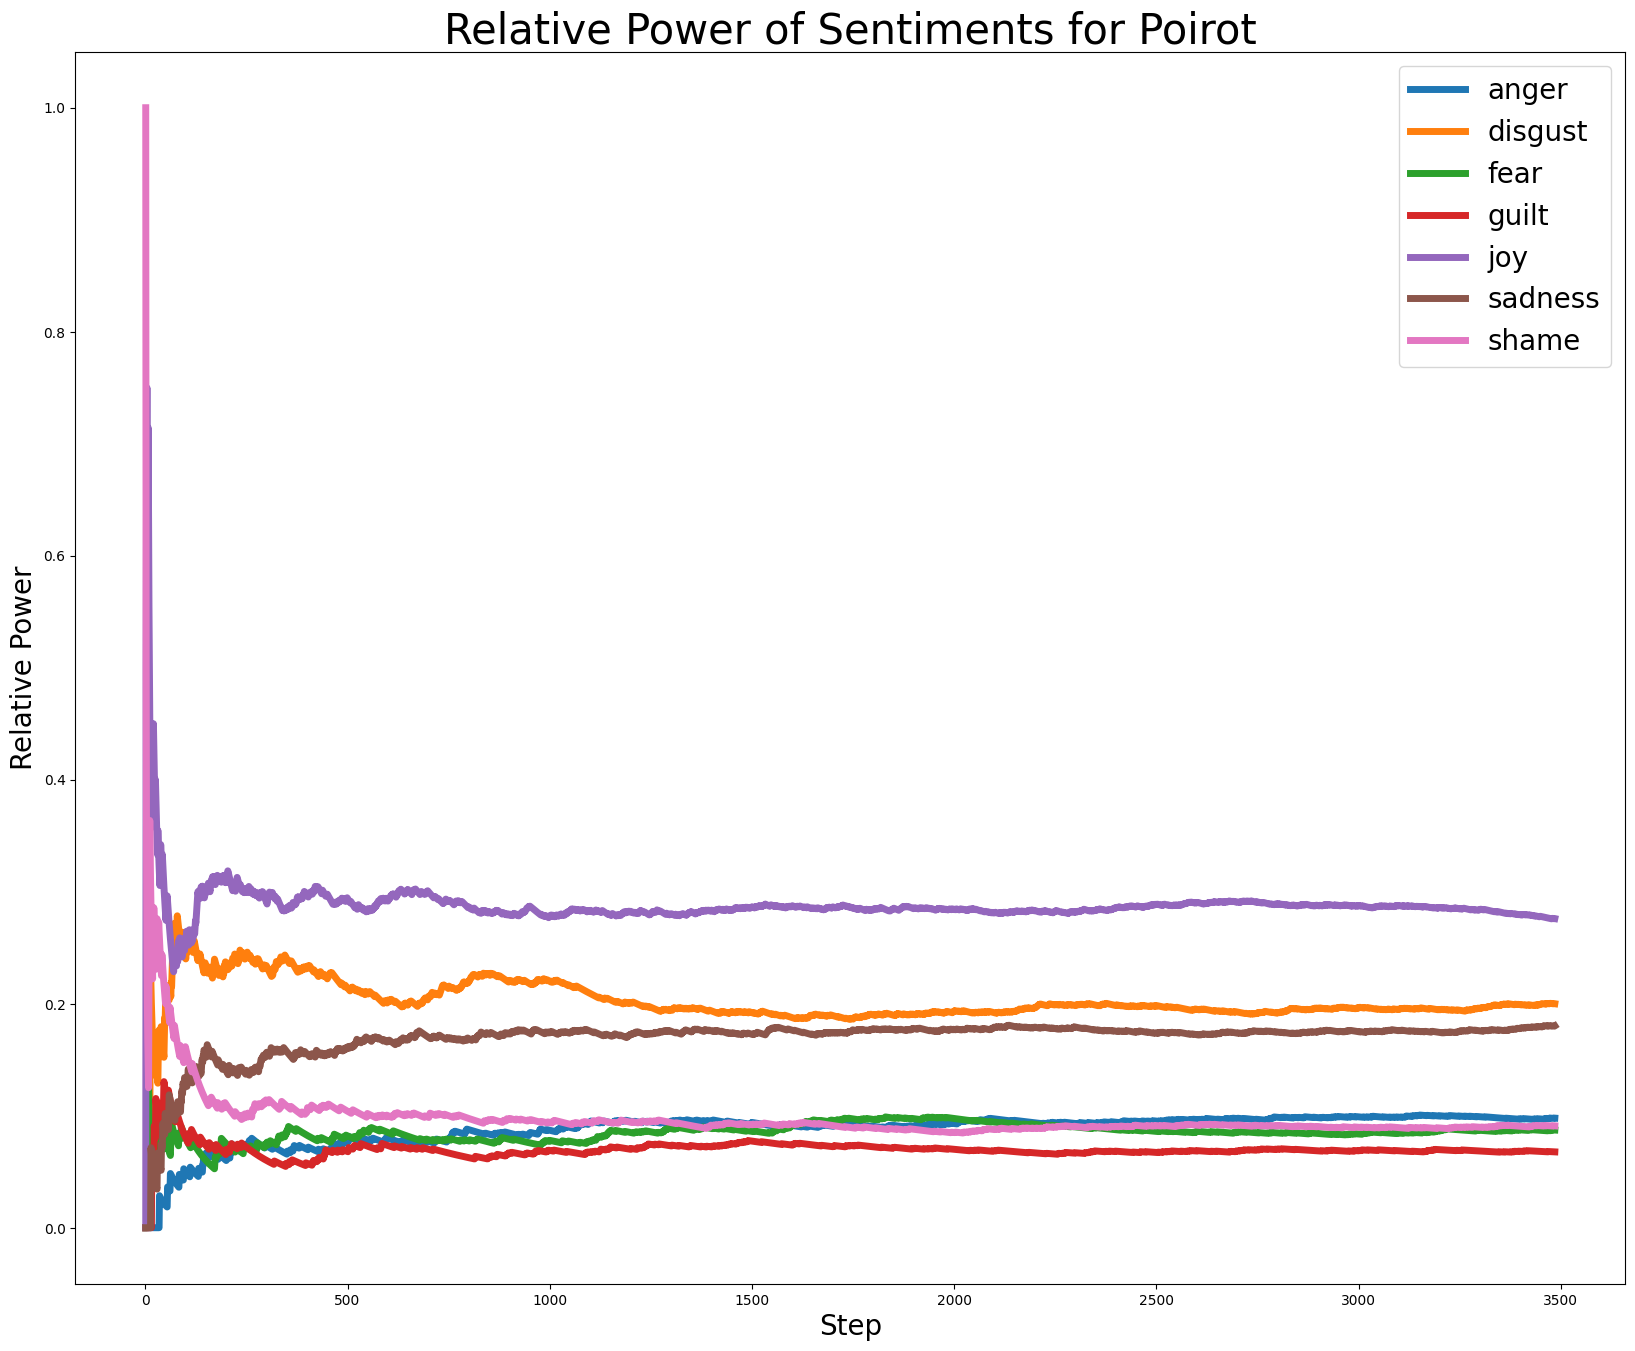

In [83]:
query = 'Poirot'
sentiments = []
sentiments = output_list
    
    # Plotting the relative powers
x = range(1, len(sentiments) + 1)  # X-axis values
labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

plt.figure(figsize=(20, 16))

for sentiment in labels:
    plt.plot(x, relative_powers[sentiment], label=sentiment, linewidth=5)

plt.xlabel('Step', fontsize=20)
plt.ylabel('Relative Power', fontsize = 20)
plt.title('Relative Power of Sentiments for {}'.format(query), fontsize=30)
plt.legend(fontsize=20)

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
plt.show()
    #return plt 

### Sentiment analysis on Hastings on all books

In [84]:
all_query_sentences = return_all_sentences('Hastings')
print(len(all_query_sentences))

The sentences that match the query are: 119
The sentences that match the query are: 68
The sentences that match the query are: 64
The sentences that match the query are: 203
The sentences that match the query are: 17
The sentences that match the query are: 2
473


In [85]:
output_list = sentiment_analysis_BERT(all_query_sentences)


100%|██████████| 473/473 [01:05<00:00,  7.28it/s]


In [86]:
relative_powers = calculate_relative_power(output_list)

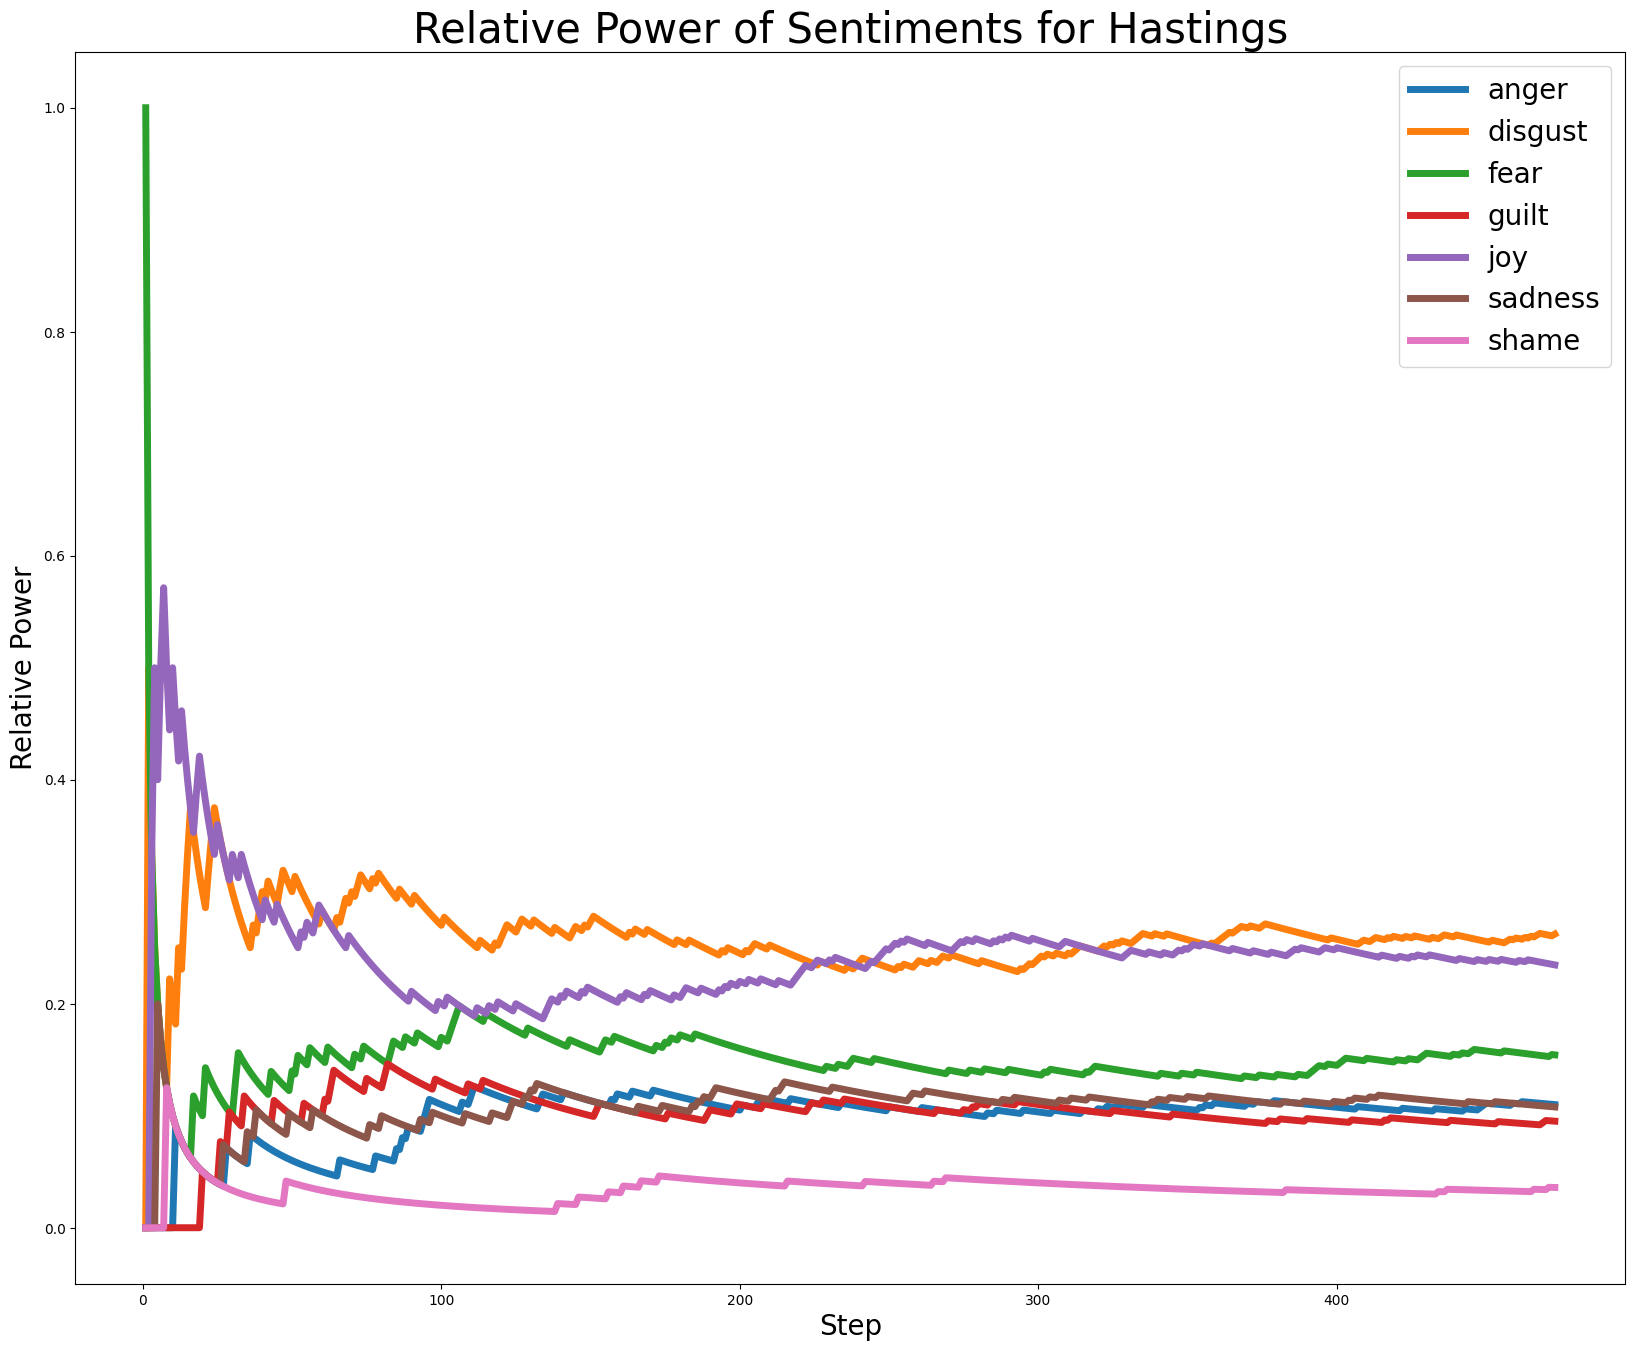

In [87]:
query = 'Hastings'
sentiments = []
sentiments = output_list
    
    # Plotting the relative powers
x = range(1, len(sentiments) + 1)  # X-axis values
labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

plt.figure(figsize=(20, 16))

for sentiment in labels:
    plt.plot(x, relative_powers[sentiment], label=sentiment, linewidth=5)

plt.xlabel('Step', fontsize=20)
plt.ylabel('Relative Power', fontsize = 20)
plt.title('Relative Power of Sentiments for {}'.format(query), fontsize=30)
plt.legend(fontsize=20)

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
plt.show()
    #return plt 

### Japp

In [88]:
all_query_sentences = return_all_sentences('Japp')
print(len(all_query_sentences))

The sentences that match the query are: 74
The sentences that match the query are: 8
The sentences that match the query are: 31
The sentences that match the query are: 74
The sentences that match the query are: 8
The sentences that match the query are: 20
215


In [89]:
output_list = sentiment_analysis_BERT(all_query_sentences)


100%|██████████| 215/215 [00:29<00:00,  7.28it/s]


In [90]:
relative_powers = calculate_relative_power(output_list)

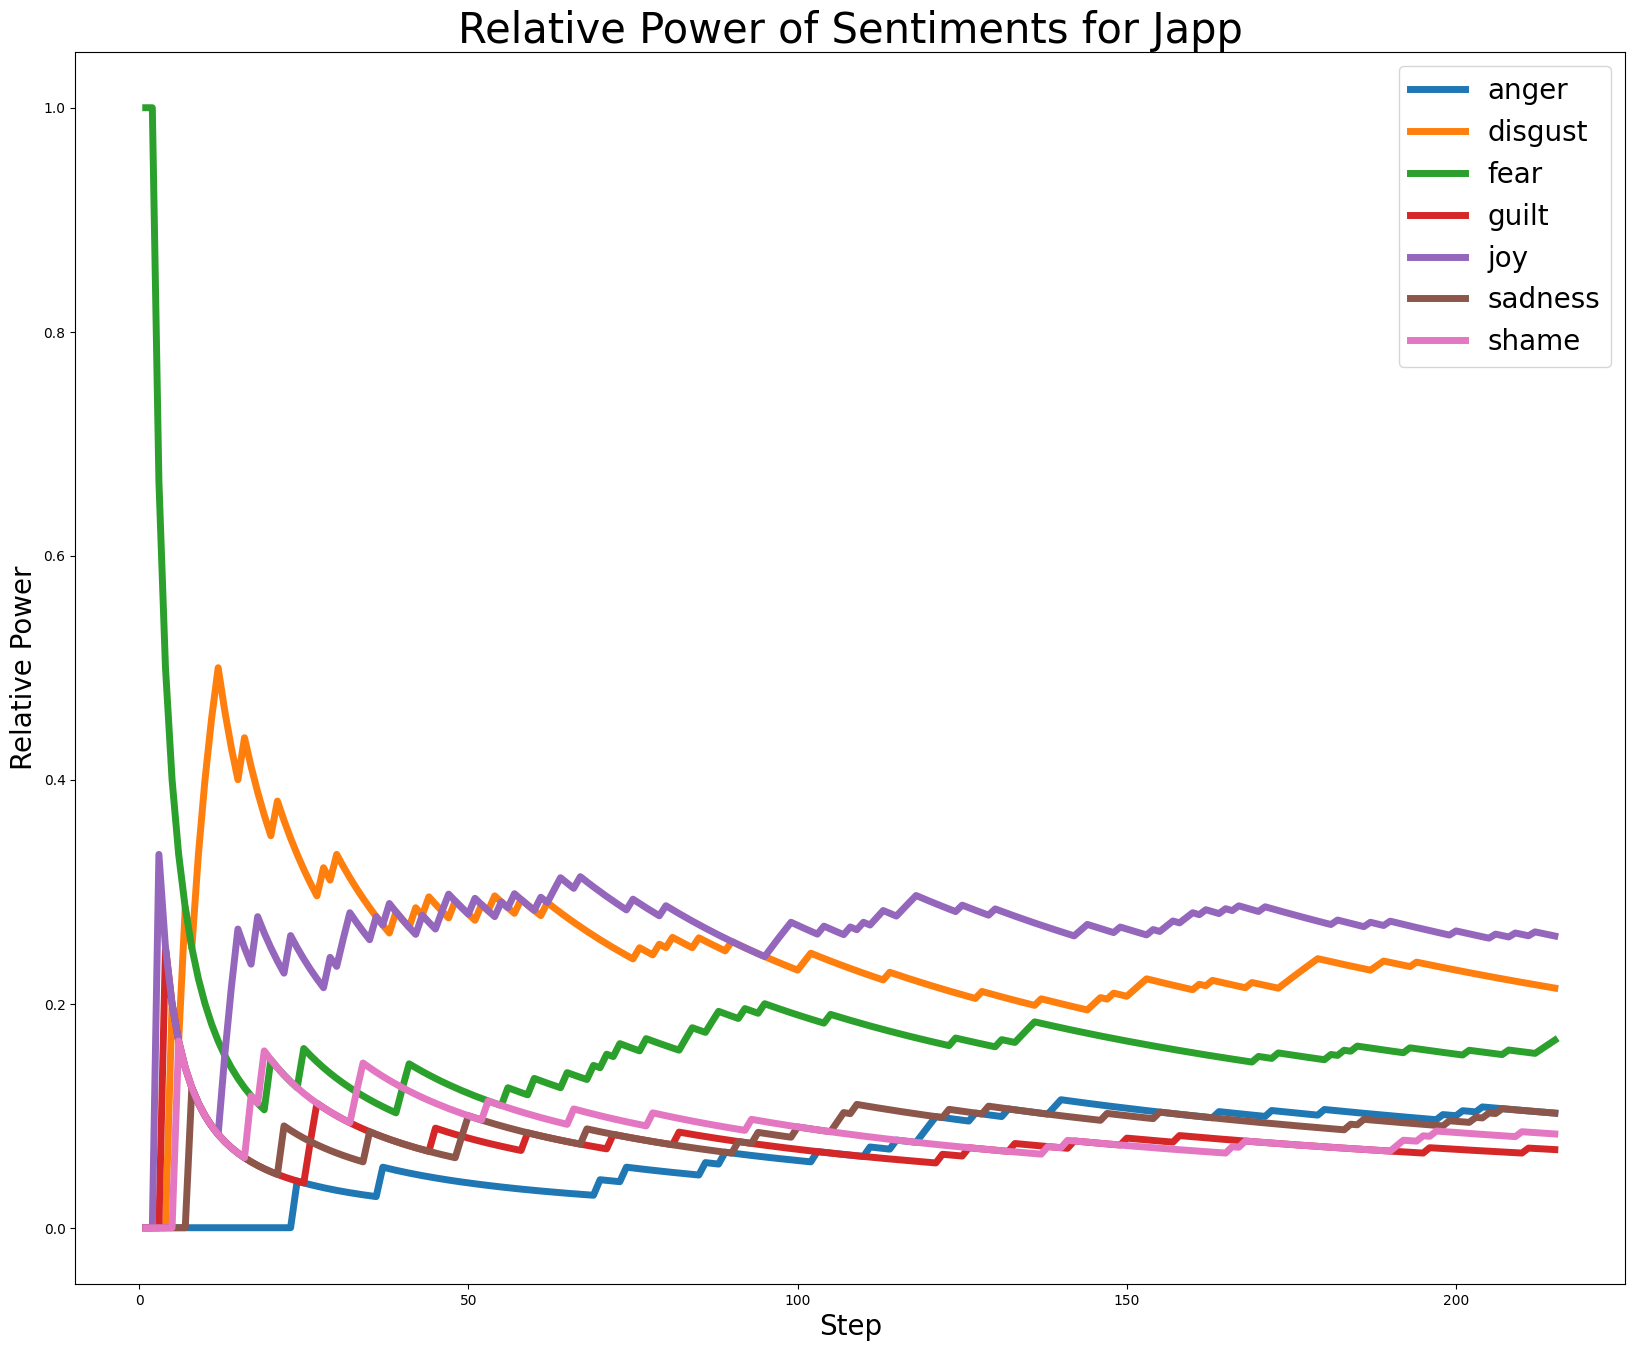

In [91]:
query = 'Japp'
sentiments = []
sentiments = output_list
    
    # Plotting the relative powers
x = range(1, len(sentiments) + 1)  # X-axis values
labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

plt.figure(figsize=(20, 16))

for sentiment in labels:
    plt.plot(x, relative_powers[sentiment], label=sentiment, linewidth=5)

plt.xlabel('Step', fontsize=20)
plt.ylabel('Relative Power', fontsize = 20)
plt.title('Relative Power of Sentiments for {}'.format(query), fontsize=30)
plt.legend(fontsize=20)

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
plt.show()
    #return plt 

### Query for another character that is present only in one book, Inglethorp

In [92]:
all_query_sentences = return_all_sentences('Inglethorp')
print(len(all_query_sentences))

The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 490
The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 0
490


In [93]:
output_list = sentiment_analysis_BERT(all_query_sentences)


100%|██████████| 490/490 [01:11<00:00,  6.82it/s]


In [94]:
relative_powers = calculate_relative_power(output_list)

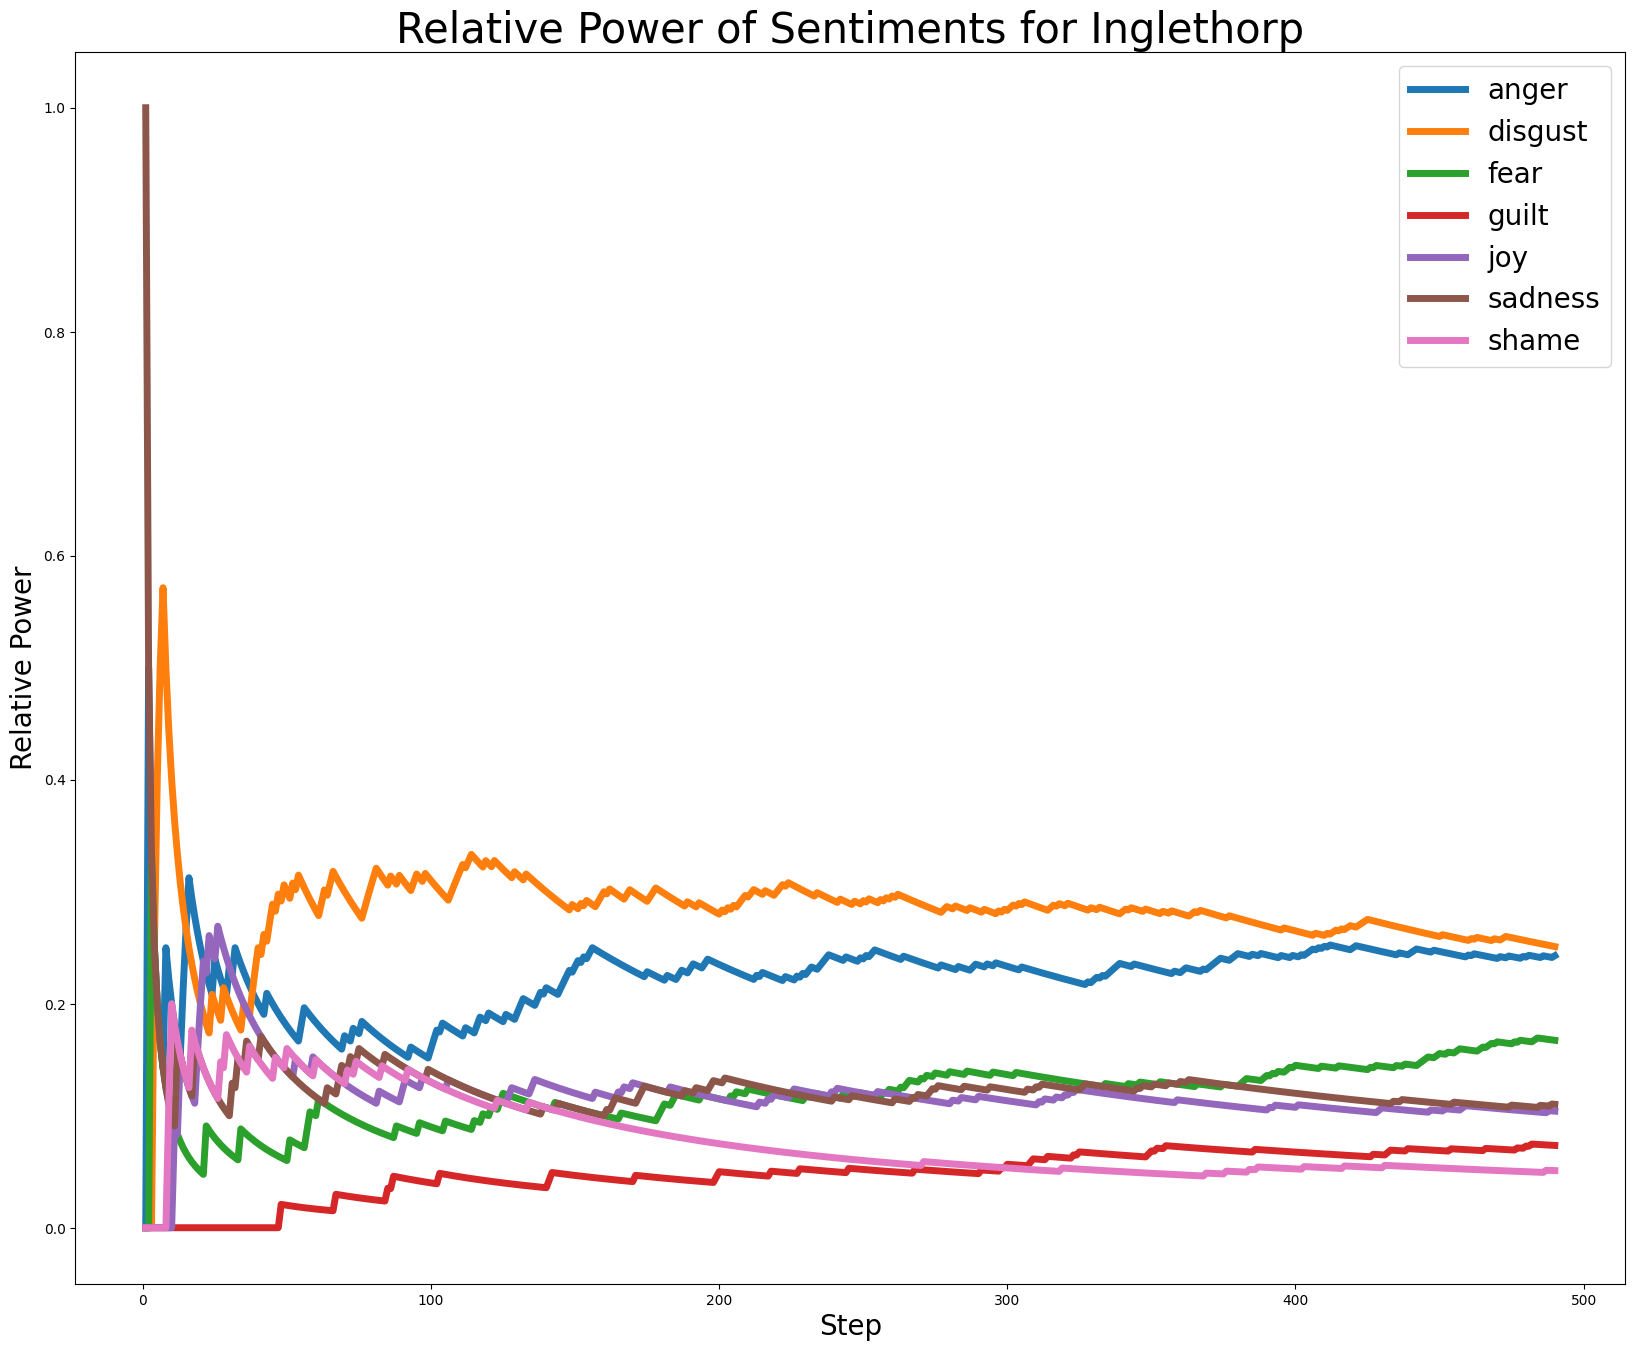

In [95]:
query = 'Inglethorp'
sentiments = []
sentiments = output_list
    
    # Plotting the relative powers
x = range(1, len(sentiments) + 1)  # X-axis values
labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

plt.figure(figsize=(20, 16))

for sentiment in labels:
    plt.plot(x, relative_powers[sentiment], label=sentiment, linewidth=5)

plt.xlabel('Step', fontsize=20)
plt.ylabel('Relative Power', fontsize = 20)
plt.title('Relative Power of Sentiments for {}'.format(query), fontsize=30)
plt.legend(fontsize=20)

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
plt.show()
    #return plt 

### Querying for another character that is present only on 2 books, Flossie

In [96]:
all_query_sentences = return_all_sentences('Flossie')
print(len(all_query_sentences))

The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 28
The sentences that match the query are: 0
The sentences that match the query are: 8
36


In [97]:
output_list = sentiment_analysis_BERT(all_query_sentences)


100%|██████████| 36/36 [00:05<00:00,  6.87it/s]


In [98]:
relative_powers = calculate_relative_power(output_list)

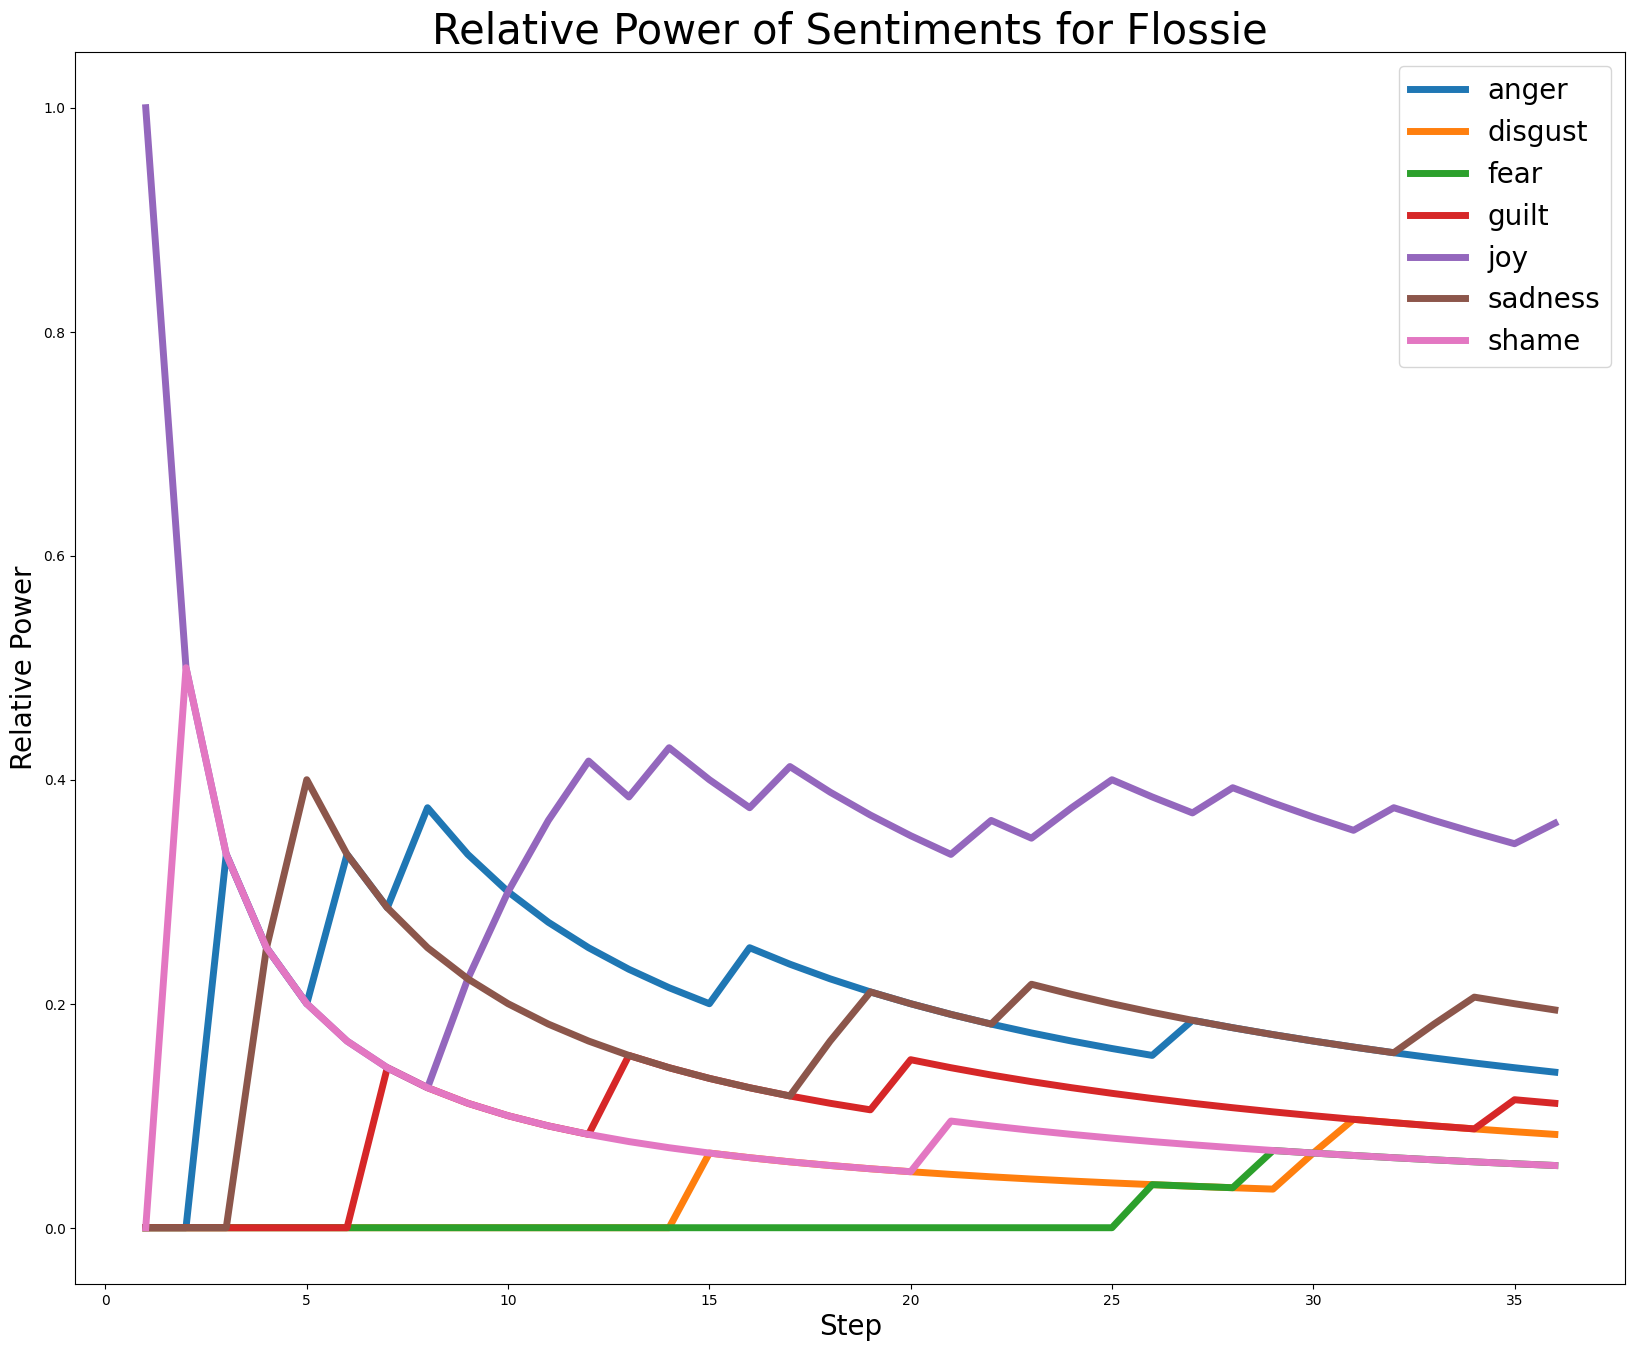

In [99]:
query = 'Flossie'
sentiments = []
sentiments = output_list
    
    # Plotting the relative powers
x = range(1, len(sentiments) + 1)  # X-axis values
labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

plt.figure(figsize=(20, 16))

for sentiment in labels:
    plt.plot(x, relative_powers[sentiment], label=sentiment, linewidth=5)

plt.xlabel('Step', fontsize=20)
plt.ylabel('Relative Power', fontsize = 20)
plt.title('Relative Power of Sentiments for {}'.format(query), fontsize=30)
plt.legend(fontsize=20)

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
plt.show()
    #return plt 

### Querying for another character, Sheppard

In [100]:
all_query_sentences = return_all_sentences('Sheppard')
print(len(all_query_sentences))

The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 124
The sentences that match the query are: 0
124


In [101]:
output_list = sentiment_analysis_BERT(all_query_sentences)


100%|██████████| 124/124 [00:19<00:00,  6.52it/s]


In [102]:
relative_powers = calculate_relative_power(output_list)

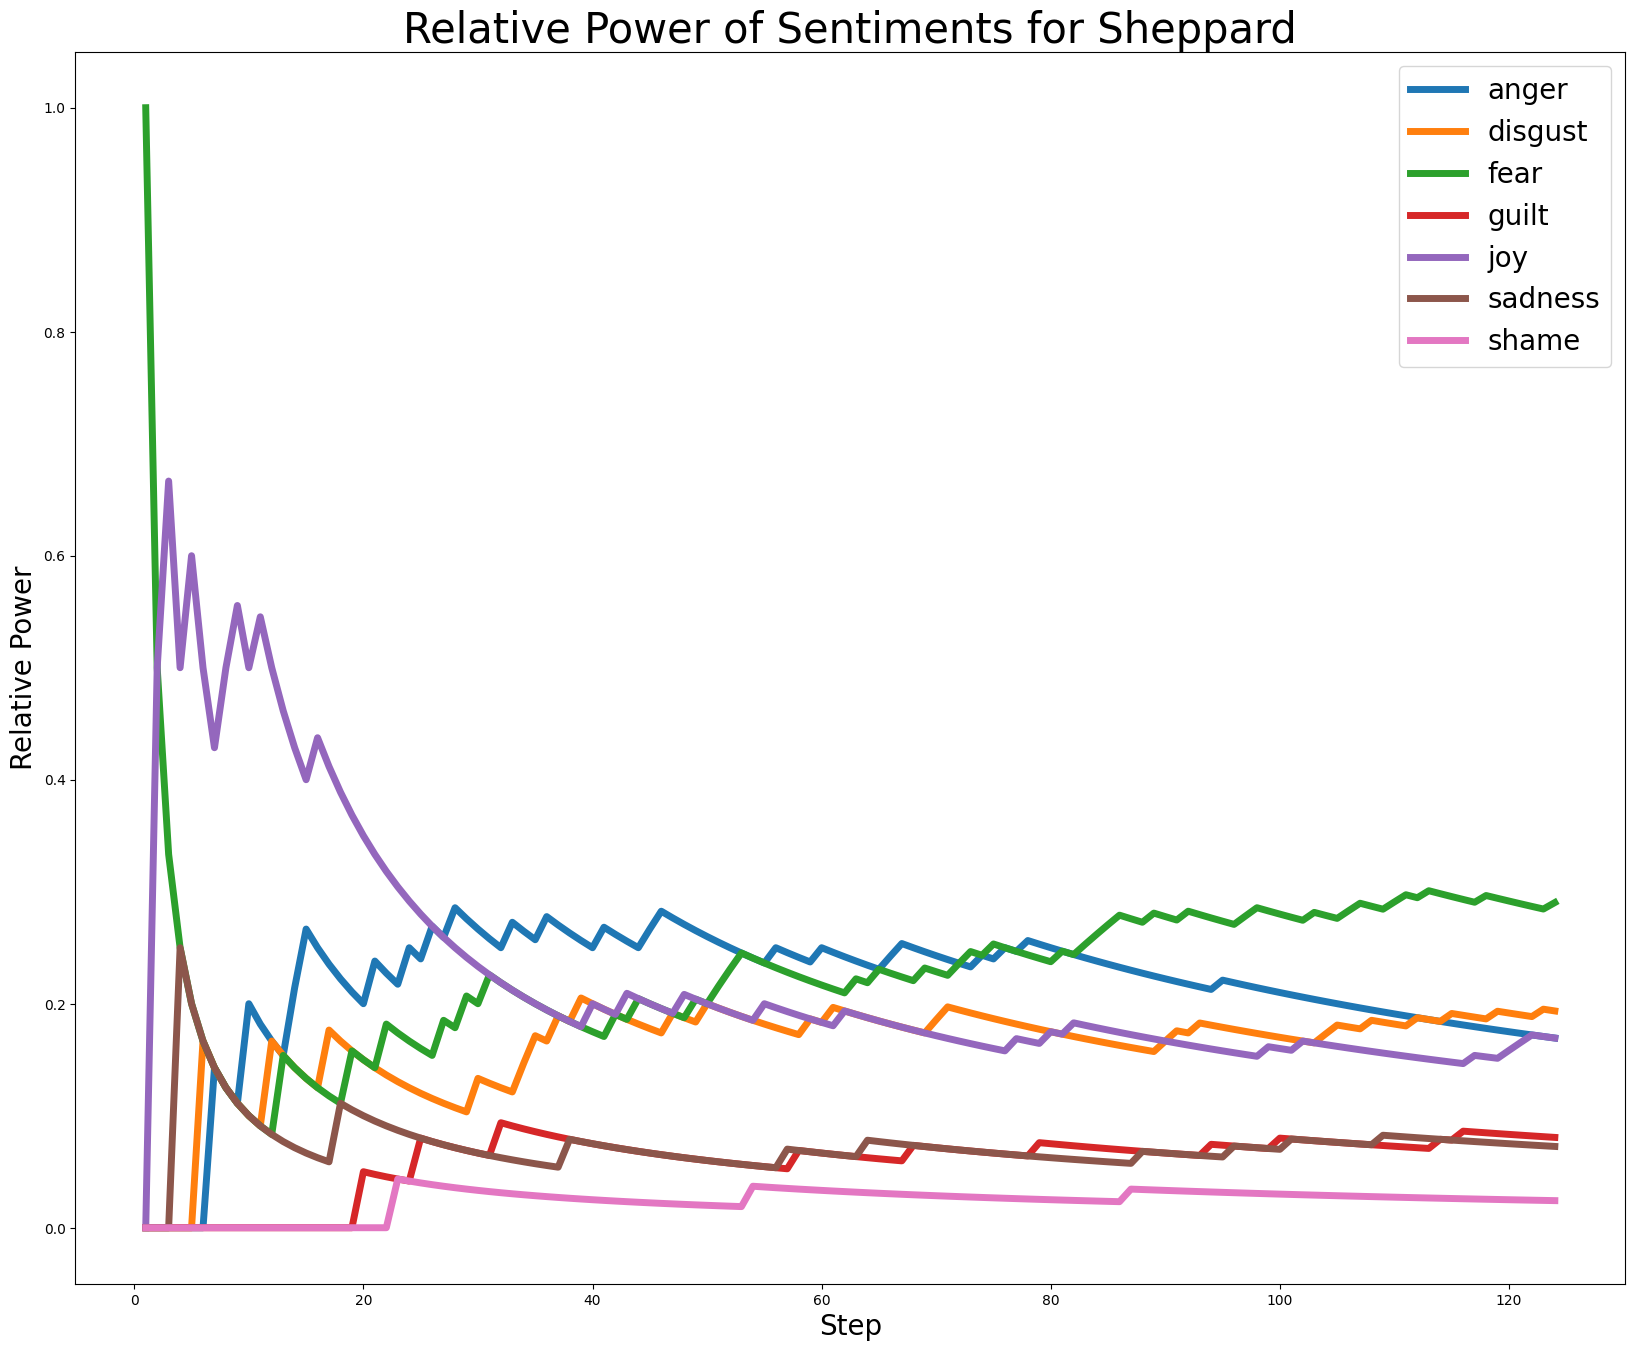

In [103]:
query = 'Sheppard'
sentiments = []
sentiments = output_list
    
    # Plotting the relative powers
x = range(1, len(sentiments) + 1)  # X-axis values
labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

plt.figure(figsize=(20, 16))

for sentiment in labels:
    plt.plot(x, relative_powers[sentiment], label=sentiment, linewidth=5)

plt.xlabel('Step', fontsize=20)
plt.ylabel('Relative Power', fontsize = 20)
plt.title('Relative Power of Sentiments for {}'.format(query), fontsize=30)
plt.legend(fontsize=20)

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
plt.show()
    #return plt 

## query for Ackroyd


In [104]:
all_query_sentences = return_all_sentences('Ackroyd')
print(len(all_query_sentences))

The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 0
The sentences that match the query are: 664
The sentences that match the query are: 0
664


In [105]:
output_list = sentiment_analysis_BERT(all_query_sentences)


100%|██████████| 664/664 [01:41<00:00,  6.57it/s]


In [106]:
relative_powers = calculate_relative_power(output_list)

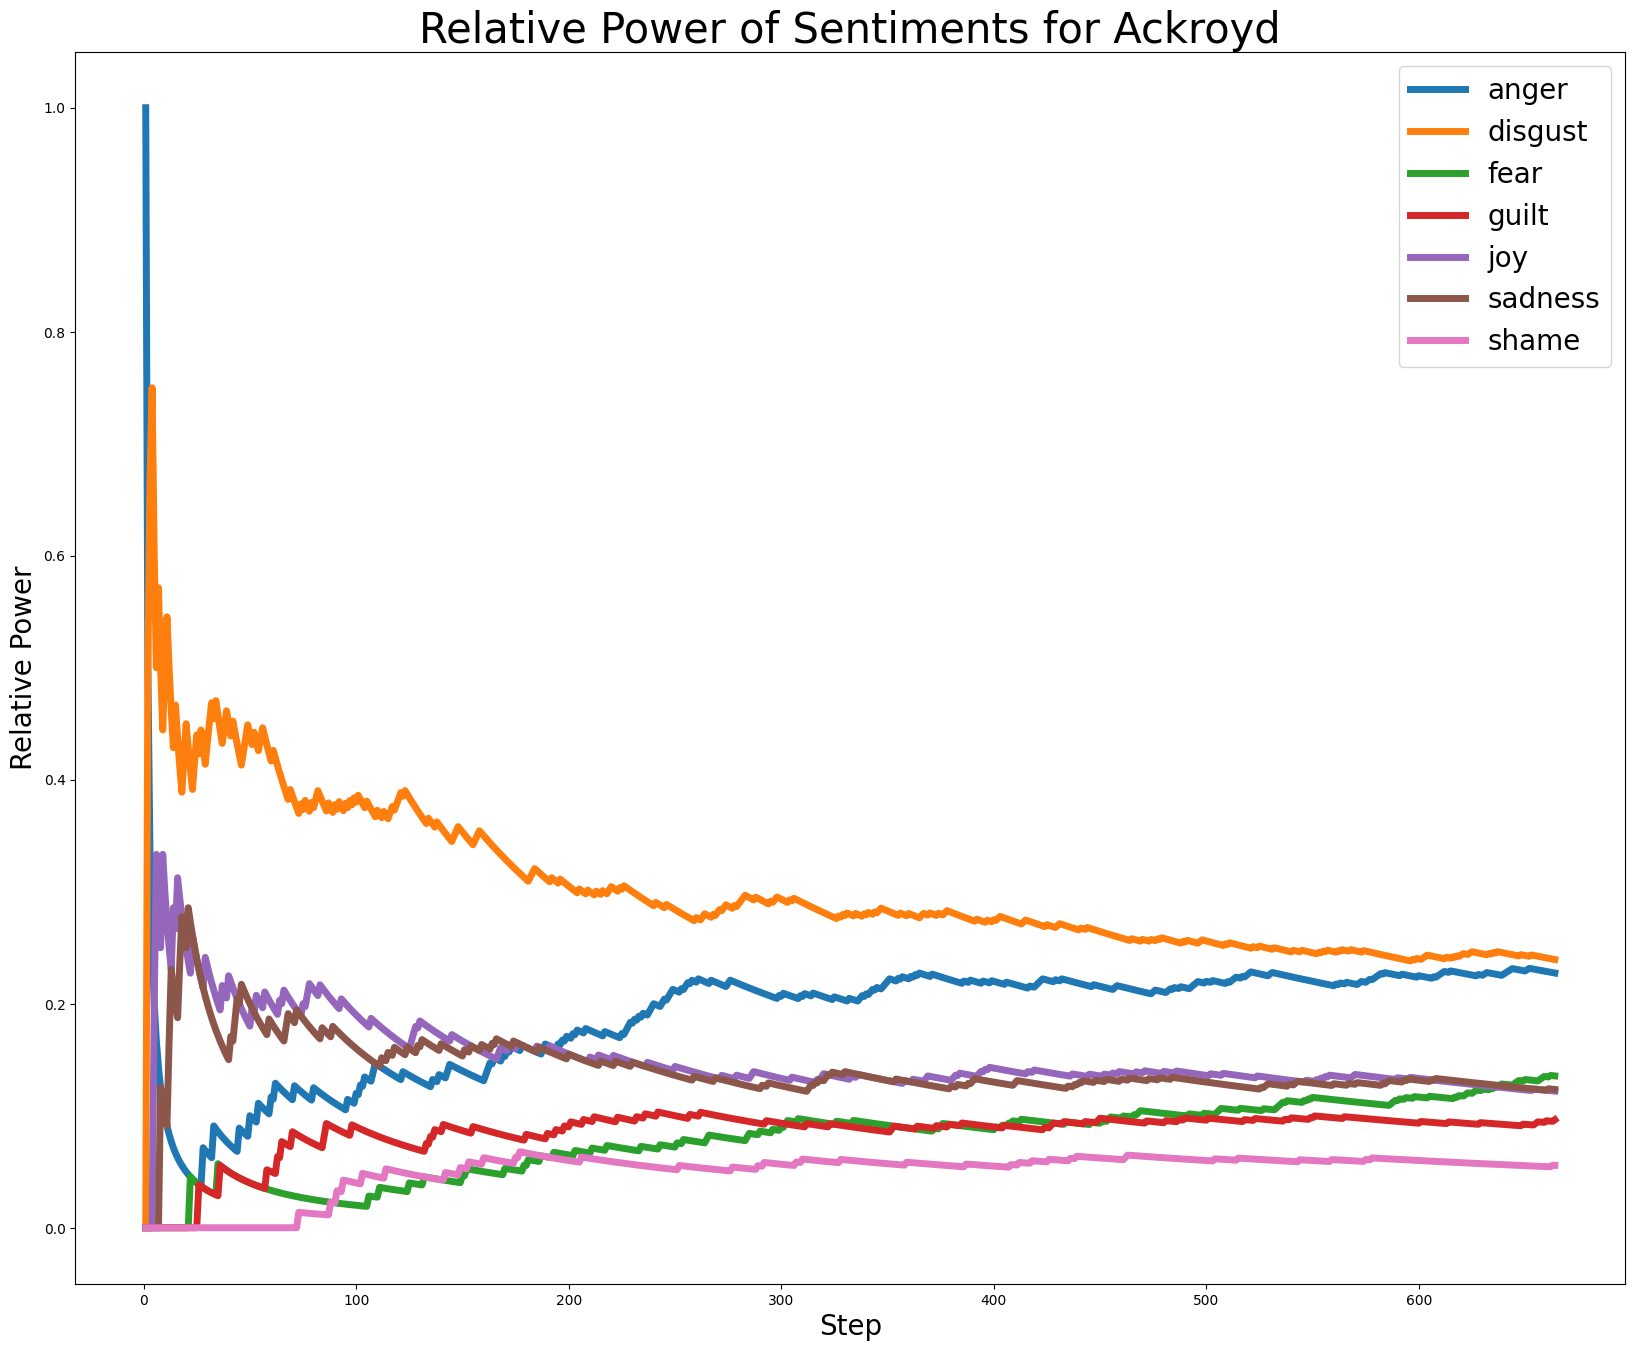

In [107]:
query = 'Ackroyd'
sentiments = []
sentiments = output_list
    
    # Plotting the relative powers
x = range(1, len(sentiments) + 1)  # X-axis values
labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

plt.figure(figsize=(20, 16))

for sentiment in labels:
    plt.plot(x, relative_powers[sentiment], label=sentiment, linewidth=5)

plt.xlabel('Step', fontsize=20)
plt.ylabel('Relative Power', fontsize = 20)
plt.title('Relative Power of Sentiments for {}'.format(query), fontsize=30)
plt.legend(fontsize=20)

    # Adding sentiment labels
    # for sentiment in labels:
    #     plt.text(len(sentiments) + 0.5, relative_powers[sentiment][-1], sentiment)
plt.show()
    #return plt 

# QUANTITATIVE RESULTS FOR SENTIMENT ANALYSIS

# Results sentiment analysis

In [129]:
### mysterious affairs at styles

test_sentence_sent1 = 'Yes, said Poirot thoughtfully, it was only natural'
test_sentence_sent2 = 'Oh, là là! That miserable cocoa! cried Poirot flippantly.'
test_sentence_sent3 = 'Come now, urged Poirot encouragingly.'

### murder on the links
test_sentence_sent4 = 'Poirot knelt down by the body.'
test_sentence_sent5 = 'Suddenly Poirot stiffened.'
test_sentence_sent6 = 'Poirot shook his head with a smile.'


### murder of roger ackroyd
test_sentence_sent7 = 'Poirot sprang up to meet me, with every appearance of pleasure.'
test_sentence_sent8 = 'Poirot stood in the middle of the hall frowning.'
test_sentence_sent9 = 'Good morning, Parker, said Poirot pleasantly.'

#Plymouth Express
test_sentence_sent10 = 'Poirot hail the first taxi we met , and direct the driver to Park Lane.'
test_sentence_sent11 = 'Poirots eye rove round the room and fasten Poirots eye on a small black trunk.'
test_sentence_sent12 = 'he depart , and Poirot gently coaxed the lock of a small black trunk with a practice hand.'

#Poirot Investigates
test_sentence_sent13 = 'All these detail pas rapidly through my mind a I join with Poirot in greet our fair client.'
test_sentence_sent14 = 'Poirot drew forward a chair for Poirot , and Poirot commenced talk at once.'
test_sentence_sent15 = 'You will probably think me very foolish , Poirot , but Lord Cronshaw be tell me last night how wonderfully you clear up the mystery of Lord Cronshaw nephew death , and I felt that I just must have your advice.'

#Big four
test_sentence_sent16 = 'Poirot give a brief explanation , and The doctor start examine our strange visitor , who seem quite unconscious of The doctor presence or ours .'
test_sentence_sent17= "a man's come here under the force of a persistent ideato find Poirot , 14 Farraway Streetand a man repeat those word mechanically without in the least know what those word mean."
test_sentence_sent18 = "I explain Hercule Poirot's 's departure and the fact that I propose to accompany a man to Southampton."
test_sentence_sent19 = 'Poirots voice altered a little, as it always did when speaking of this particular individual.'
test_sentence_sent20 = 'Then Poirot led her gently back to the subject of Claud Darrell.'
test_sentence_sent21 = 'And then, to test her, Poirot embarked upon a long history of a poisoning case in which a guilty wife had figured.'

### random sentences from all books
test_sentence_sent22 = 'Oh, if only Poirot had been there to solve the problem with his lightning ingenuity!'
test_sentence_sent23 = 'Poirots bewilderment vanished.'
test_sentence_sent24 = 'It occurred to me that there was not much which escaped Hercule Poirot.'
test_sentence_sent25 = 'No, no, my child, said Poirot kindly.'
test_sentence_sent26 = 'You do not trust me, said Poirot gently.'
test_sentence_sent27 = 'Poirot rapped gently on a table and cleared his throat significantly.'
test_sentence_sent28 = 'Poirot was busy mopping a grey suit with a minute sponge.'
test_sentence_sent29 = 'So, said Poirot thoughtfully, there are two disappearances: the Prime Minister in France, and OMurphy in London.'
test_sentence_sent30 = 'Pas du tout, replied Poirot tranquilly.'


#Plymouth Express
test_sentence_sent31 = 'Poirot withdrew from a small black trunk a coat and skirt of bright blue frieze , and a small toque of white fox fur.'
test_sentence_sent32 = "Poirot wave a deprecate hand , then help Poirot to more caviare."
test_sentence_sent33 = "Poirot smile modestly , and murmur to Halliday : Japp , Japp shall get the official credit , all right , but though Japp have get Japp Gracie Kidd , I think that I , a the Americans say , have get Japp goat !."

#Poirot Investigates
test_sentence_sent34 = "When Poirot return , I enjoy tell Poirot the tale of what have occur during Poirot absence ."
test_sentence_sent35 = "Poirot crossquestioned me rather sharply over the detail of we conversation and I could read between the line that Poirot be not best pleased to have be absent ."
test_sentence_sent36 = "cry Poirot , step back a pace and regard me with admiration."

#Big Four
test_sentence_sent37 = 'Poirot be out , but I know for a fact that hell be back very shortly .'
test_sentence_sent38 = 'Poirot thanked me and sat down.'
test_sentence_sent39 = 'In Poirots presence I have frequently felt a difficultyI do not appear at my best .'
test_sentence_sent40 = "Poor boy , I do wonder what 's become of Poirot himself ."





In [130]:
test_sentences_sent = [test_sentence_sent1,
                       test_sentence_sent2,
                       test_sentence_sent3,
                       test_sentence_sent4,
                       test_sentence_sent5,
                       test_sentence_sent6,
                       test_sentence_sent7,
                       test_sentence_sent8,
                       test_sentence_sent9,
                       test_sentence_sent10,
                       test_sentence_sent11,
                       test_sentence_sent12,
                       test_sentence_sent13,
                       test_sentence_sent14,
                       test_sentence_sent15,
                       test_sentence_sent16,
                       test_sentence_sent17,
                       test_sentence_sent18,
                       test_sentence_sent19,
                       test_sentence_sent20,
                       test_sentence_sent21,
                       test_sentence_sent22,
                       test_sentence_sent23,
                       test_sentence_sent24,
                       test_sentence_sent25,
                       test_sentence_sent26,
                       test_sentence_sent27,
                       test_sentence_sent28,
                       test_sentence_sent29,
                       test_sentence_sent30,
                       test_sentence_sent31,
                       test_sentence_sent32,
                       test_sentence_sent33,
                       test_sentence_sent34,
                       test_sentence_sent35,
                       test_sentence_sent36,
                       test_sentence_sent37,
                       test_sentence_sent38,
                       test_sentence_sent39,
                       test_sentence_sent40]

In [131]:
sentiments_measure_bert = sentiment_analysis_BERT(test_sentences_sent)

100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


In [132]:
names

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [133]:
for index, test_sentence in enumerate(test_sentences_sent):
    print(f'The sentence is:{index+1}')
    print(test_sentence)
    print('The predicted sentiment from BERT is:')
    print(sentiments_measure_bert[index])
    print('-'*30)

The sentence is:1
Yes, said Poirot thoughtfully, it was only natural
The predicted sentiment from BERT is:
joy
------------------------------
The sentence is:2
Oh, là là! That miserable cocoa! cried Poirot flippantly.
The predicted sentiment from BERT is:
sadness
------------------------------
The sentence is:3
Come now, urged Poirot encouragingly.
The predicted sentiment from BERT is:
joy
------------------------------
The sentence is:4
Poirot knelt down by the body.
The predicted sentiment from BERT is:
sadness
------------------------------
The sentence is:5
Suddenly Poirot stiffened.
The predicted sentiment from BERT is:
sadness
------------------------------
The sentence is:6
Poirot shook his head with a smile.
The predicted sentiment from BERT is:
joy
------------------------------
The sentence is:7
Poirot sprang up to meet me, with every appearance of pleasure.
The predicted sentiment from BERT is:
joy
------------------------------
The sentence is:8
Poirot stood in the middle o

In [134]:
names

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [135]:
df_sent = pd.read_excel('results_ner.xlsx', sheet_name=1)
df_sent

Sentence Sentiment BERT annotator 1 annotator2
0          1            joy         joy        joy
1          2        sadness     sadness    sadness
2          3            joy         joy        joy
3          4        sadness        fear    sadness
4          5        sadness       shame       fear
5          6            joy         joy        joy
6          7            joy         joy        joy
7          8        disgust     disgust    disgust
8          9            joy         joy        joy
9         10           fear         joy      anger
10        11           fear     sadness       fear
11        12            joy        fear        joy
12        13            joy         joy        joy
13        14          shame         joy      anger
14        15          guilt       shame      shame
15        16           fear       anger      guilt
16        17        disgust     disgust       fear
17        18          guilt       guilt        joy
18        19          shame       shame       fear
19        20            joy         joy        joy
20        21        disgust       anger      guilt
21        22        sadness     sadness        joy
22        23        sadness       shame      shame
23        24        sadness         joy      guilt
24        25        sadness         joy       fear
25        26        sadness     sadness    sadness
26        27            joy       shame        joy
27        28        disgust     disgust        joy
28        29           fear        fear      guilt
29        30            joy         joy        joy
30        31            joy       shame        joy
31        32        disgust         joy        joy
32        33          guilt         joy        joy
33        34            joy         joy        joy
34        35          anger       anger      shame
35        36            joy         joy        joy
36        37           fear        fear        joy
37        38            joy         joy        joy
38        39          shame       shame      shame
39        40        sadness     sadness    disgust

In [136]:
cohen_kappa_score(df_sent['Sentiment BERT'], df_sent['annotator 1'])

0.4900398406374502

In [137]:
cohen_kappa_score(df_sent['annotator2'], df_sent['annotator 1'])

0.28873835732430153

In [138]:
print(classification_report(df_sent['annotator 1'], df_sent['Sentiment BERT']))

              precision    recall  f1-score   support

       anger       1.00      0.33      0.50         3
     disgust       0.60      1.00      0.75         3
        fear       0.40      0.50      0.44         4
       guilt       0.33      1.00      0.50         1
         joy       0.79      0.65      0.71        17
     sadness       0.44      0.80      0.57         5
       shame       0.67      0.29      0.40         7

    accuracy                           0.60        40
   macro avg       0.60      0.65      0.55        40
weighted avg       0.67      0.60      0.59        40



In [139]:
print(classification_report(df_sent['annotator2'], df_sent['Sentiment BERT']))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         2
     disgust       0.20      0.50      0.29         2
        fear       0.20      0.20      0.20         5
       guilt       0.00      0.00      0.00         4
         joy       1.00      0.70      0.82        20
     sadness       0.33      1.00      0.50         3
       shame       0.33      0.25      0.29         4

    accuracy                           0.50        40
   macro avg       0.30      0.38      0.30        40
weighted avg       0.59      0.50      0.52        40



# SIA results


In [141]:
df_sent2 = pd.read_excel('results_ner.xlsx', sheet_name=2)
df_sent2

Sentence SIA prediction annotator1 annotator2
0          1       positive   positive   positive
1          2       negative   negative   negative
2          3       positive   positive    neutral
3          4        neutral   negative   negative
4          5        neutral   negative   negative
5          6       positive   positive   positive
6          7       positive   positive   positive
7          8       negative    neutral   negative
8          9       positive   positive   positive
9         10       positive    neutral    neutral
10        11        neutral    neutral    neutral
11        12       positive   negative    neutral
12        13       positive   positive   positive
13        14        neutral    neutral    neutral
14        15       positive   negative   positive
15        16       negative   negative   negative
16        17        neutral   negative   negative
17        18        neutral    neutral    neutral
18        19        neutral   negative    neutral
19        20       positive   positive   positive
20        21       negative   negative   negative
21        22       negative   positive   negative
22        23        neutral   negative   negative
23        24        neutral   positive   negative
24        25       negative   positive   positive
25        26       positive   negative   negative
26        27       positive    neutral   positive
27        28       positive    neutral   negative
28        29       positive   negative   positive
29        30       positive   positive   positive
30        31       positive    neutral   positive
31        32       positive    neutral   positive
32        33       positive   positive   positive
33        34       positive   positive   negative
34        35       negative   negative   negative
35        36       positive   negative   positive
36        37       negative    neutral   positive
37        38       positive   positive   negative
38        39       positive   negative   positive
39        40       negative   negative   negative

In [142]:
cohen_kappa_score(df_sent2['annotator1'], df_sent2['annotator2'])

0.3436293436293436

In [143]:
cohen_kappa_score(df_sent2['annotator1'], df_sent2['SIA prediction'])

0.20604914933837426

In [144]:
cohen_kappa_score(df_sent2['annotator2'], df_sent2['SIA prediction'])

0.450441609421001

In [145]:
print(classification_report(df_sent2['annotator2'], df_sent2['SIA prediction']))

              precision    recall  f1-score   support

    negative       0.78      0.44      0.56        16
     neutral       0.44      0.57      0.50         7
    positive       0.68      0.88      0.77        17

    accuracy                           0.65        40
   macro avg       0.63      0.63      0.61        40
weighted avg       0.68      0.65      0.64        40



In [146]:
print(classification_report(df_sent2['annotator1'], df_sent2['SIA prediction']))

              precision    recall  f1-score   support

    negative       0.56      0.31      0.40        16
     neutral       0.33      0.30      0.32        10
    positive       0.50      0.79      0.61        14

    accuracy                           0.48        40
   macro avg       0.46      0.47      0.44        40
weighted avg       0.48      0.47      0.45        40



# LIME FOR BERT SENTIMENT ANALYSIS


In [147]:
from lime.lime_text import LimeTextExplainer
import warnings
warnings.filterwarnings("ignore")

In [148]:
import torch.nn.functional as F
def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    tensor_logits = outputs[0]
    probabilities = F.softmax(tensor_logits).detach().numpy()
    return probabilities

In [149]:
sample_text = test_sentences_sent[9]

In [150]:
explainer = LimeTextExplainer(class_names=names)
exp = explainer.explain_instance(sample_text, predictor, num_features=20, num_samples=20)
exp.show_in_notebook(text=sample_text)

# TRACKING POIROT THROUGH THE BOOKS WITH SPACY

In [108]:
type(spacy_ner_list[0][0].label_)

str

In [109]:
type(spacy_ner_list[0])

tuple

In [110]:
complete_loc_list = []

start = time.time()

for index, text in enumerate(spacy_ner_list):
    print(f"Finding locations from text number = {index}")
    for index2, ent in enumerate(text):
        if ent.label_ == 'LOC':
            complete_loc_list.append(ent.text)
            
    print(f"Found locations from text number = {index}")
    
end = time.time()    
print(f"\nFound all locations from all books in: {end-start} seconds")    

Finding locations from text number = 0
Found locations from text number = 0
Finding locations from text number = 1
Found locations from text number = 1
Finding locations from text number = 2
Found locations from text number = 2
Finding locations from text number = 3
Found locations from text number = 3
Finding locations from text number = 4
Found locations from text number = 4
Finding locations from text number = 5
Found locations from text number = 5

Found all locations from all books in: 0.005862712860107422 seconds


In [111]:
print(len(complete_loc_list))

156


In [112]:
complete_token_list = []

for index, text in enumerate(resolved_text_list):
    
    print(f"Tokenizing text number {index}")
    
    complete_token_list.append(nltk.word_tokenize(text))
        
    print(f"Finished tokenizing text number {index}")
    
print(len(complete_token_list))    

Tokenizing text number 0
Finished tokenizing text number 0
Tokenizing text number 1
Finished tokenizing text number 1
Tokenizing text number 2
Finished tokenizing text number 2
Tokenizing text number 3
Finished tokenizing text number 3
Tokenizing text number 4
Finished tokenizing text number 4
Tokenizing text number 5
Finished tokenizing text number 5
6


In [113]:
complete_token_list = complete_token_list[0] + complete_token_list[1] + complete_token_list[2] + complete_token_list[3] + complete_token_list[4] + complete_token_list[5]

In [114]:
print(len(complete_token_list))

383073


# TRACKING POIROT THROUGH THE BOOKS WITH FLAIRNLP

In [115]:
# resolved_text_list = [resolved_poirot_investigates, 
#                       resolved_murder_on_the_links,
#                       resolved_mysterious_affairs_at_styles,
#                       resolved_the_big_four,
#                       resolved_murder_of_roger_ackroyd,
#                       resolved_plymouth_express]

In [116]:
from flair.nn import Classifier
from flair.data import Sentence
from flair.splitter import SegtokSentenceSplitter
# load the model
tagger = Classifier.load('ner')

2023-05-29 21:35:36,261 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [117]:
start = time.time()


text = resolved_poirot_investigates + resolved_murder_on_the_links + resolved_mysterious_affairs_at_styles + resolved_the_big_four + resolved_murder_of_roger_ackroyd + resolved_plymouth_express 

# initialize sentence splitter
splitter = SegtokSentenceSplitter()

# use splitter to split text into list of sentences
sentences = splitter.split(text)

# predict tags for sentences
tagger.predict(sentences)

end = time.time()

print(f"The time to tag all NE with FlairNLP was: {end-start} seconds") ### typically 320 seconds



The time to tag all NE with FlairNLP was: 285.0607783794403 seconds


In [118]:
flair_locs_full = []
flair_locs_names = []
flair_sentences = []

### A location is added to the list only if Poirot is mentioned in the same sentence, the previous one or the next one.
### This is done to somewhat skip the times that someone is introduced and poirot is not there
### Of course there are limitations which are discussed in the report


# iterate through sentences and print predicted labels
for index, sentence in enumerate(sentences):
    if len(sentence.get_labels()) > 0:
        for label in sentence.get_labels():
            # print label value and score
            #print(f'label.value is: "{label.value}"')
            #print(f'label.score is: "{label.score}"')
            # access the data point to which label attaches and print its text
            #print(f'the text of label.data_point is: "{label.data_point.text}"\n')
            if label.value == "LOC" and label.data_point.text!='Poirot' and label.data_point.text!='Poirots' and ("Poirot" in sentences[index].text or "Poirot" in sentences[index-1].text or "Poirot" in sentences[index+1].text):
                flair_locs_full.append(label)
                flair_locs_names.append(label.data_point.text)
                flair_sentences.append(sentence)
  






In [119]:
print(f"According to FlairNLP, Poirot has been in {len(flair_locs_full)} locations through the 6 books")

According to FlairNLP, Poirot has been in 390 locations through the 6 books


In [193]:
import geopy
import folium
from folium.plugins import TimestampedGeoJson
from datetime import datetime, timedelta

def geocode_location(location):
    geolocator = geopy.Nominatim(user_agent="my_app")
    try:
        location_data = geolocator.geocode(location)
        if location_data is not None:
            return location_data.latitude, location_data.longitude
        else:
            return None
    except (geopy.exc.GeocoderTimedOut, geopy.exc.GeocoderUnavailable):
        return geocode_location(location)

# Example list of location names
locations = flair_locs_names[100:130] ### the visualization is done for a small amount of points, because 400 locations would clutter the map

# Create an empty list to hold the frames
frames = []

# Set initial timestamp
timestamp = datetime.now()

# Iterate over the location list and add frames for each location
for i, location in enumerate(locations):
    coords = geocode_location(location)
    if coords is not None:
        frame = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [coords[1], coords[0]]  # Note: Reverse order for coordinates (longitude, latitude)
            },
            "properties": {
                "time": timestamp.strftime('%Y-%m-%d'),  # Assign the timestamp to each frame
                "popup": location  # Add a popup text for the location
            }
        }
        frames.append(frame)
        # Increment the timestamp by one day for the next location
        timestamp += timedelta(days=1)

# Create an empty map
route_map = folium.Map(zoom_start=2)

# Create a GeoJSON feature collection with all the frames
feature_collection = {
    "type": "FeatureCollection",
    "features": frames
}

# Create a single TimestampedGeoJson layer with all the frames
timestamped_layer = TimestampedGeoJson(feature_collection, period='P1D', add_last_point=True, auto_play=True)

# Add the TimestampedGeoJson layer to the map
timestamped_layer.add_to(route_map)

# Display the map
route_map

route_map.save("route_map_poirot_filtered_flairv2.html")


# TRACKING HASTINGS THROUGH THE BOOKS WITH FLAIRNLP


In [ ]:
# resolved_text_list = [resolved_poirot_investigates, 
#                       resolved_murder_on_the_links,
#                       resolved_mysterious_affairs_at_styles,
#                       resolved_the_big_four,
#                       resolved_murder_of_roger_ackroyd,
#                       resolved_plymouth_express]

In [145]:
from flair.nn import Classifier
from flair.data import Sentence
from flair.splitter import SegtokSentenceSplitter
# load the model
tagger = Classifier.load('ner')

2023-05-28 15:27:50,546 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [146]:
start = time.time()


text = resolved_poirot_investigates + resolved_murder_on_the_links + resolved_mysterious_affairs_at_styles + resolved_the_big_four + resolved_murder_of_roger_ackroyd + resolved_plymouth_express 

# initialize sentence splitter
splitter = SegtokSentenceSplitter()

# use splitter to split text into list of sentences
sentences = splitter.split(text)

# predict tags for sentences
tagger.predict(sentences)

end = time.time()

print(f"The time to tag all NE with FlairNLP was: {end-start} seconds") ### typically 320 seconds



The time to tag all NE with FlairNLP was: 261.207790851593 seconds


In [147]:
flair_locs_full = []
flair_locs_names = []
flair_sentences = []

### A location is added to the list only if the name Hastings is mentioned in the same sentence, the previous one or the next one.
### This is done to somewhat skip the times that someone is introduced and hastings is not there
### Of course there are limitations which are discussed in the report


# iterate through sentences and print predicted labels
for index, sentence in enumerate(sentences):
    if len(sentence.get_labels()) > 0:
        for label in sentence.get_labels():
            # print label value and score
            #print(f'label.value is: "{label.value}"')
            #print(f'label.score is: "{label.score}"')
            # access the data point to which label attaches and print its text
            #print(f'the text of label.data_point is: "{label.data_point.text}"\n')
            if label.value == "LOC" and label.data_point.text!='Hastings' and label.data_point.text!='Hasting' and ("Hasting" in sentences[index].text or "Hasting" in sentences[index-1].text or "Hasting" in sentences[index+1].text):
                flair_locs_full.append(label)
                flair_locs_names.append(label.data_point.text)
                flair_sentences.append(sentence)
  






In [148]:
print(f"According to FlairNLP, Hasting has been in {len(flair_locs_full)} locations through the 6 books")

According to FlairNLP, Hasting has been in 92 locations through the 6 books


In [149]:
import geopy
import folium
from folium.plugins import TimestampedGeoJson
from datetime import datetime, timedelta

def geocode_location(location):
    geolocator = geopy.Nominatim(user_agent="my_app")
    try:
        location_data = geolocator.geocode(location)
        if location_data is not None:
            return location_data.latitude, location_data.longitude
        else:
            return None
    except (geopy.exc.GeocoderTimedOut, geopy.exc.GeocoderUnavailable):
        return geocode_location(location)

# Example list of location names
locations = flair_locs_names[10:35] ### the visualization is done for a small amount of points, because 100 locations would clutter the map

# Create an empty list to hold the frames
frames = []

# Set initial timestamp
timestamp = datetime.now()

# Iterate over the location list and add frames for each location
for i, location in enumerate(locations):
    coords = geocode_location(location)
    if coords is not None:
        frame = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [coords[1], coords[0]]  # Note: Reverse order for coordinates (longitude, latitude)
            },
            "properties": {
                "time": timestamp.strftime('%Y-%m-%d'),  # Assign the timestamp to each frame
                "popup": location  # Add a popup text for the location
            }
        }
        frames.append(frame)
        # Increment the timestamp by one day for the next location
        timestamp += timedelta(days=1)

# Create an empty map
route_map = folium.Map(zoom_start=2)

# Create a GeoJSON feature collection with all the frames
feature_collection = {
    "type": "FeatureCollection",
    "features": frames
}

# Create a single TimestampedGeoJson layer with all the frames
timestamped_layer = TimestampedGeoJson(feature_collection, period='P1D', add_last_point=True, auto_play=True)

# Add the TimestampedGeoJson layer to the map
timestamped_layer.add_to(route_map)

# Display the map
route_map

route_map.save("route_map_hasting_filtered_flairv2.html")


## Precision recall curve for BERT classification sentiment

In [128]:
def sentiment_analysis_BERT2(sentences):
    
    output_list = []
    logit_list = []
    
    for sent in tqdm(sentences):

        inputs = tokenizer(sent, return_tensors="pt")

        outputs = model(**inputs)
    
        output_list.append(names[outputs['logits'][0].argmax()])
        logits = outputs['logits'][0]
        logit_list.append(logits.detach().numpy())
    
    return output_list, logit_list

In [129]:
ttt, out = sentiment_analysis_BERT2(test_sentences_sent)

100%|██████████| 40/40 [00:05<00:00,  7.26it/s]


In [130]:
len(out)

40

In [131]:
out_probas = scipy.special.softmax(out, axis=1)

In [132]:
out_probas[0].sum()

1.0

In [135]:
y_test = df_sent['annotator 1']
y_scores = out_probas 

In [136]:
y_scores.shape

(40, 7)

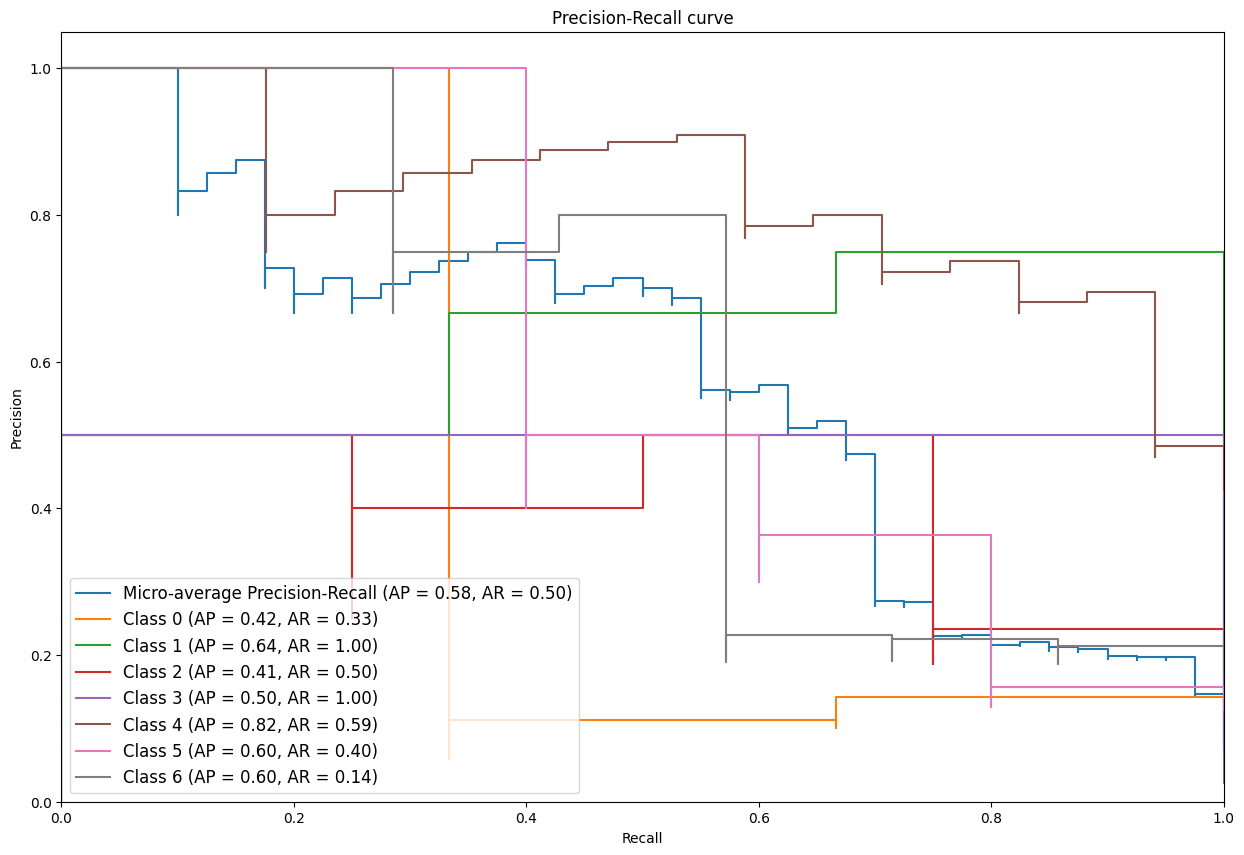

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, recall_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_scores = out_probas

# Compute precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
average_recall = dict()
n_classes = y_scores.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    average_recall[i] = recall_score(y_test_bin[:, i], y_scores[:, i].round())

# Compute micro-average precision and recall
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_scores.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_scores, average="micro")
average_recall["micro"] = recall_score(y_test_bin, y_scores.round(), average="micro")

# Plot the precision-recall curve
plt.figure(figsize=(15, 10))
plt.step(recall["micro"], precision["micro"], where="post", label="Micro-average Precision-Recall (AP = {:.2f}, AR = {:.2f})".format(average_precision["micro"], average_recall["micro"]))
for i in range(n_classes):
    plt.step(recall[i], precision[i], where="post", label="Class {} (AP = {:.2f}, AR = {:.2f})".format(i, average_precision[i], average_recall[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve")
plt.legend(loc="lower left", fontsize=12)
plt.show()


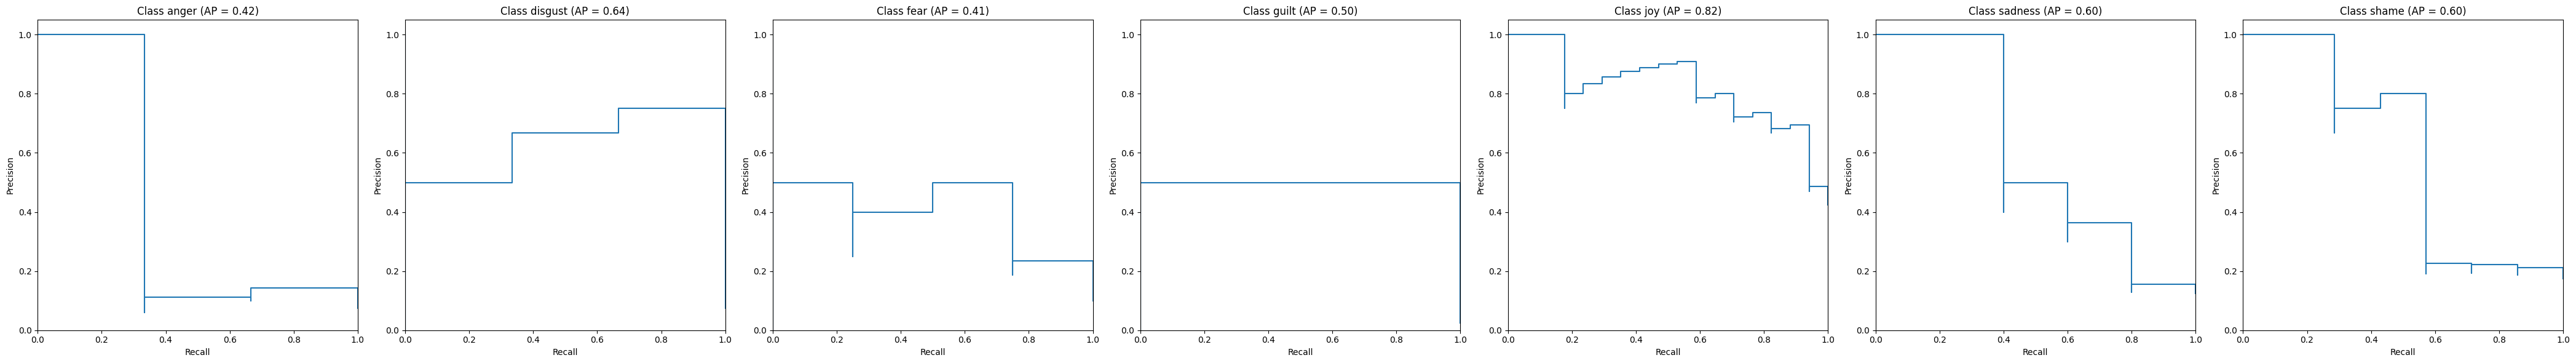

In [251]:
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])

# Create subplots
fig, axs = plt.subplots(1, n_classes, figsize=(6*n_classes, 6))

# Plot the precision-recall curves on subplots
for i in range(n_classes):
    axs[i].step(recall[i], precision[i], where="post")
    axs[i].set_xlabel("Recall")
    axs[i].set_ylabel("Precision")
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_title("Class {} (AP = {:.2f})".format(names[i], average_precision[i]))

plt.tight_layout()
plt.show()

In [246]:
names

['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']

In [263]:
type(y_scores)

numpy.ndarray

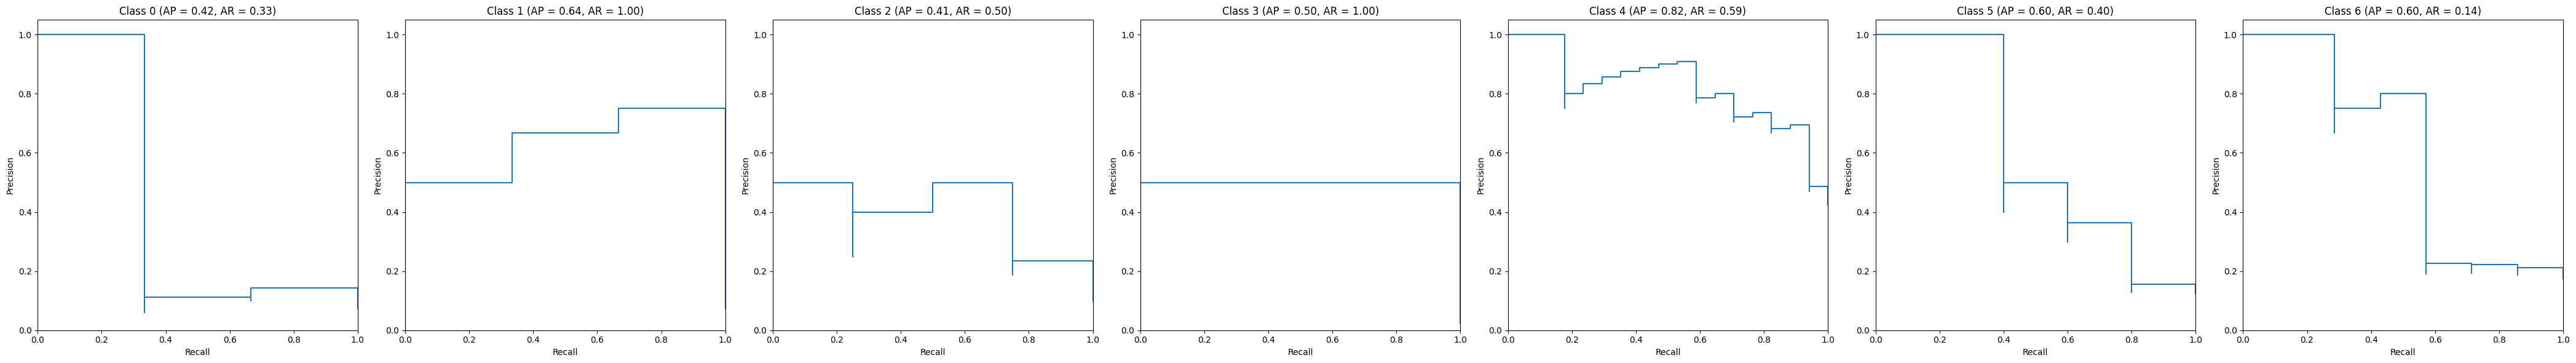

In [272]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
average_recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    average_recall[i] = recall_score(y_test_bin[:, i], y_scores[:, i].round())

# Create subplots
fig, axs = plt.subplots(1, n_classes, figsize=(6*n_classes, 6))

# Plot the precision-recall curves on subplots
for i in range(n_classes):
    axs[i].step(recall[i], precision[i], where="post")
    axs[i].set_xlabel("Recall")
    axs[i].set_ylabel("Precision")
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_title("Class {} (AP = {:.2f}, AR = {:.2f})".format(i, average_precision[i], average_recall[i]))

plt.tight_layout()
plt.show()

# Interpolation for Precision Recall curve


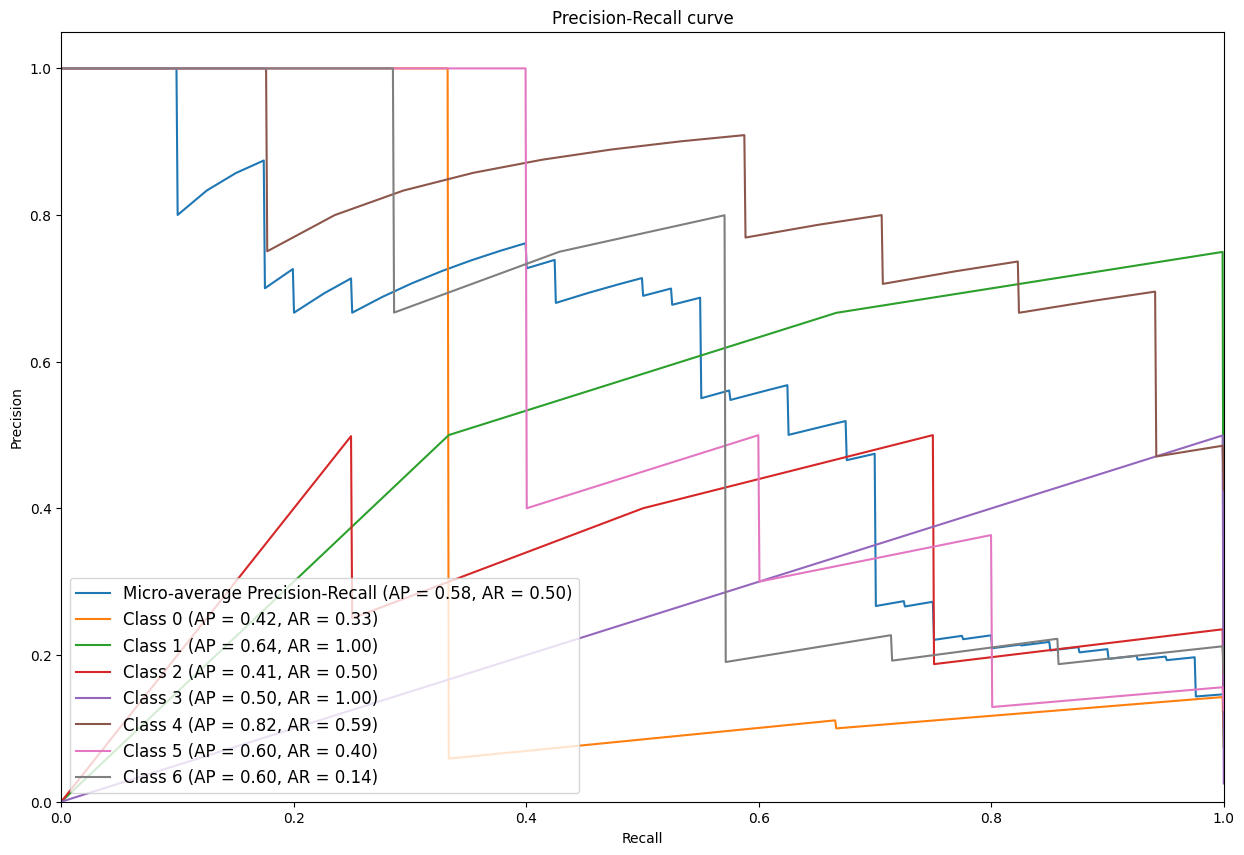

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, recall_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_scores = out_probas

# Compute precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
average_recall = dict()
n_classes = y_scores.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    average_recall[i] = recall_score(y_test_bin[:, i], y_scores[:, i].round())

# Compute micro-average precision and recall
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_scores.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_scores, average="micro")
average_recall["micro"] = recall_score(y_test_bin, y_scores.round(), average="micro")

# Generate a higher density of points for precision and recall
interp_precision = dict()
interp_recall = dict()
interp_points = 1000  # Number of points for interpolation

for i in range(n_classes):
    interp_precision[i] = np.interp(np.linspace(0, 1, interp_points), recall[i][::-1], precision[i][::-1])
    interp_recall[i] = np.linspace(0, 1, interp_points)

interp_precision["micro"] = np.interp(np.linspace(0, 1, interp_points), recall["micro"][::-1], precision["micro"][::-1])
interp_recall["micro"] = np.linspace(0, 1, interp_points)

# Plot the precision-recall curve with higher density of points
plt.figure(figsize=(15, 10))
plt.plot(interp_recall["micro"], interp_precision["micro"], linestyle='-', label="Micro-average Precision-Recall (AP = {:.2f}, AR = {:.2f})".format(average_precision["micro"], average_recall["micro"]))

for i in range(n_classes):
    plt.plot(interp_recall[i], interp_precision[i], linestyle='-', label="Class {} (AP = {:.2f}, AR = {:.2f})".format(i, average_precision[i], average_recall[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall curve")
plt.legend(loc="lower left", fontsize=12)
plt.show()


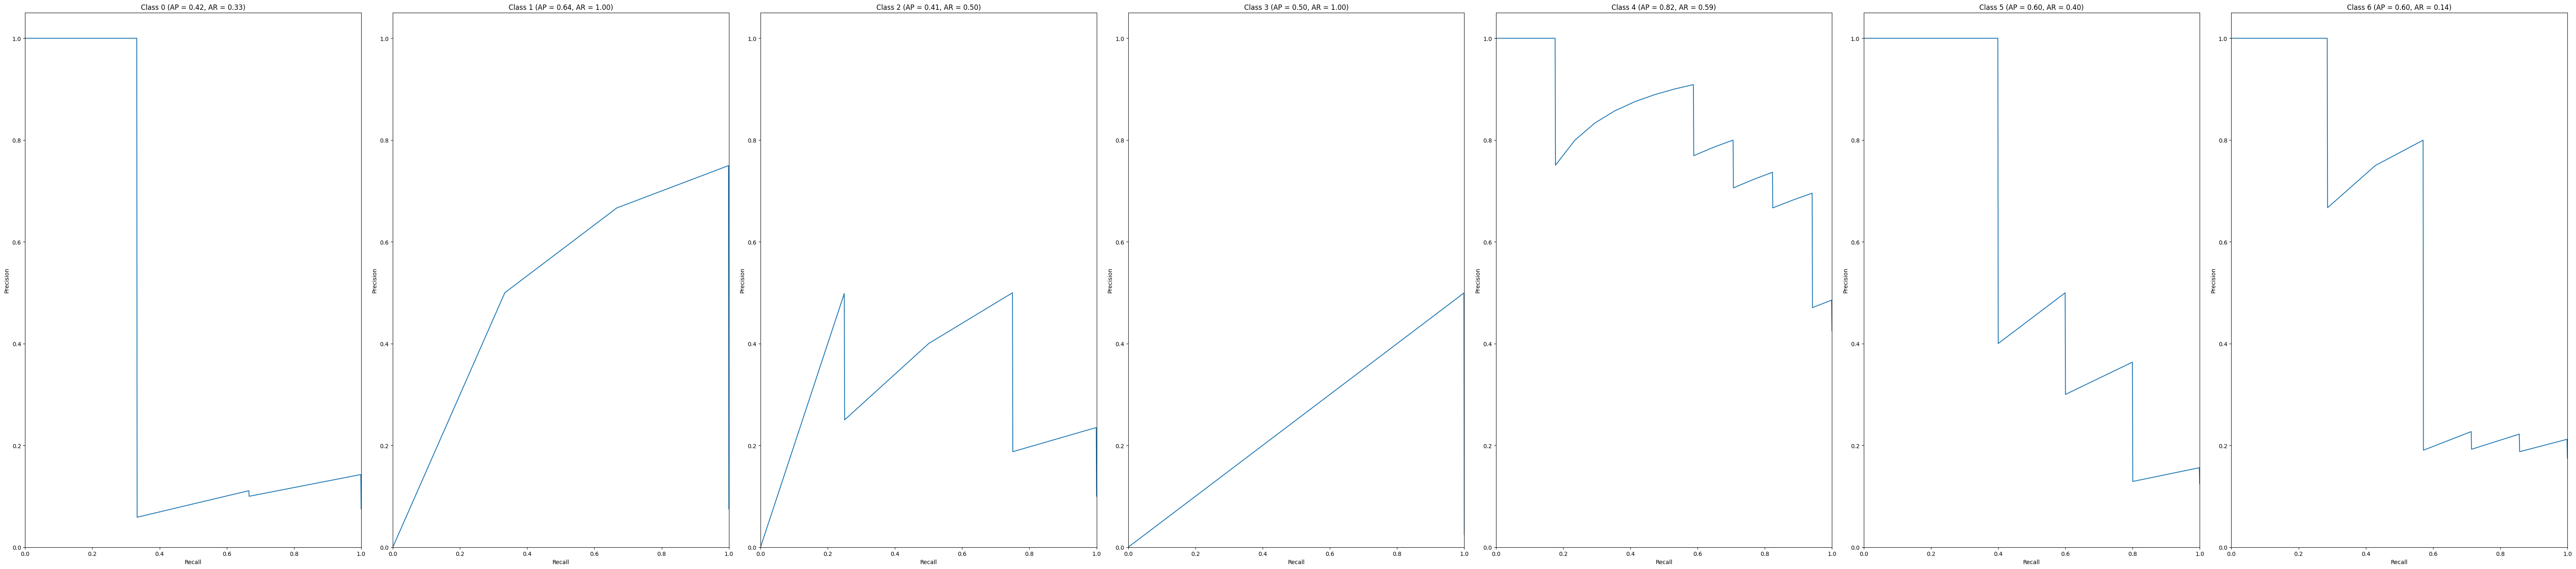

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, recall_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
average_precision = dict()
average_recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_scores[:, i])
    average_recall[i] = recall_score(y_test_bin[:, i], y_scores[:, i].round())

# Create subplots
fig, axs = plt.subplots(1, n_classes, figsize=(9 * n_classes, 14))

# Generate a higher density of points for precision and recall
interp_precision = dict()
interp_recall = dict()
interp_points = 1000  # Number of points for interpolation

for i in range(n_classes):
    interp_precision[i] = np.interp(np.linspace(0, 1, interp_points), recall[i][::-1], precision[i][::-1])
    interp_recall[i] = np.linspace(0, 1, interp_points)

# Plot the precision-recall curves on subplots
for i in range(n_classes):
    axs[i].plot(interp_recall[i], interp_precision[i], '-')
    axs[i].set_xlabel("Recall")
    axs[i].set_ylabel("Precision")
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_title("Class {} (AP = {:.2f}, AR = {:.2f})".format(i, average_precision[i], average_recall[i]))

plt.tight_layout()
plt.show()


# ENTITY LINKING

In [51]:
from flair.nn import Classifier
from flair.data import Sentence

# load the model
tagger = Classifier.load('linker')

# make a sentence
sentence = Sentence(test_sentences_ner[7])

# predict entity links
tagger.predict(sentence)

# iterate over predicted entities and print
for label in sentence.get_labels():
    print(label)

2023-05-29 20:56:33,815 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Span[1:3]: "Dulcibella Sisters" → <unk> (1.0)
Span[7:8]: "Palace" → Palace (0.7899)
Span[9:10]: "Coventry" → Coventry (0.9997)


# RELATION LINKING


In [153]:
from flair.data import Sentence
from flair.nn import Classifier

tagger = Classifier.load('ner-fast')
extractor = Classifier.load('relations')


2023-05-29 23:29:02,284 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [155]:
# make example sentence
sentence = Sentence(test_sentences_ner[7])


#load entity tagger and predict entities
tagger.predict(sentence)

# check which named entities have been found in the sentence
entities = sentence.get_labels('ner')

print(sentence)
for entity in entities:
    print(entity)

#load relation extractor

# predict relations
extractor.predict(sentence)

# check which relations have been found
relations = sentence.get_labels('relation')
for relation in relations:
    print(relation)

# Use the `get_labels()` method with parameter 'relation' to iterate over all relation predictions. 
for label in sentence.get_labels('relation'):
    print(label)

Sentence[11]: "The Dulcibella Sisters are on at the Palace in Coventry." → ["Dulcibella Sisters"/ORG, "Palace"/LOC, "Coventry"/LOC]
Span[1:3]: "Dulcibella Sisters" → ORG (0.5454)
Span[7:8]: "Palace" → LOC (0.637)
Span[9:10]: "Coventry" → LOC (0.9995)
Relation[1:3][9:10]: "Dulcibella Sisters -> Coventry" → based_in (0.9762)
Relation[1:3][9:10]: "Dulcibella Sisters -> Coventry" → based_in (0.9762)


# NEGATION HANDLING

In [156]:
from flair.nn import Classifier
from flair.data import Sentence

# load the model
tagger = Classifier.load('negation-speculation')



2023-05-29 23:34:49,862 SequenceTagger predicts: Dictionary with 8 tags: <unk>, O, B-NEGATION, I-NEGATION, B-SPECULATION, I-SPECULATION, <START>, <STOP>


In [157]:
# make a sentence
sentence = Sentence("Why wouldn't I want to go there?")

# predict entity links
tagger.predict(sentence)

# iterate over predicted entities and print
for label in sentence.get_labels():
    print(label)

Span[1:8]: "wouldn't I want to go there" → SPECULATION (0.9898)


# LIST OF INSTALLED PACKAGES, PIP FREEZE, PIP LIST

In [158]:
!pip freeze

accelerate==0.19.0
aiohttp==3.8.4
aiosignal==1.3.1
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
async-timeout==4.0.2
attrs @ file:///C:/b/abs_09s3y775ra/croot/attrs_1668696195628/work
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
beautifulsoup4 @ file:///C:/b/abs_0agyz1wsr4/croot/beautifulsoup4-split_1681493048687/work
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
blis==0.7.9
boto3==1.26.138
botocore==1.29.138
bpemb==0.3.4
branca==0.6.0
catalogue==2.0.8
certifi==2022.12.7
cffi @ file:///C:/b/abs_49n3v2hyhr/croot/cffi_1670423218144/work
charset-normalizer==2.1.1
click==8.1.3
cloudpickle==2.2.1
colorama @ file:///C:/b/abs_a9ozq0l032/croot/colorama_1672387194846/work
comm @ file:///C:/b/abs_1419earm7u/croot/comm_1671231131638/work

In [159]:
!pip list

Package                            Version
---------------------------------- ------------
accelerate                         0.19.0
aiohttp                            3.8.4
aiosignal                          1.3.1
anyio                              3.5.0
argon2-cffi                        21.3.0
argon2-cffi-bindings               21.2.0
asttokens                          2.0.5
async-timeout                      4.0.2
attrs                              22.1.0
backcall                           0.2.0
beautifulsoup4                     4.12.2
bleach                             4.1.0
blis                               0.7.9
boto3                              1.26.138
botocore                           1.29.138
bpemb                              0.3.4
branca                             0.6.0
catalogue                          2.0.8
certifi                            2022.12.7
cffi                               1.15.1
charset-normalizer                 2.1.1
click                           